### COG260 project: Color category focus locations also reflect optimal partitions of color space
Olivia Townsend and Alex Heyman

In [29]:
from wcs_helper_functions_alt import *

In [30]:
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats
from random import random
%matplotlib inline
from statistics import mode
from collections import Counter
import random

random.seed(1)

### 1. Construct Modal Map
Construct a modal map for each language from the WCS data.

In [31]:
'''
Return the most frequent gloss from color_chip_glosses.
If multiple glosses are equally frequent, randomly return any one of them.
'''
def get_most_frequent_gloss(color_chip_glosses): 

    most_frequent_glosses = []
    gloss_count = Counter(color_chip_glosses)
    gloss_count_ordered = gloss_count.most_common() # ascending order of frequency
    greatest_frequency = gloss_count_ordered[0][1]
    most_frequent_glosses.append(gloss_count_ordered[0][0])
    
    for i in range(1, len(gloss_count_ordered)):
        
        if gloss_count_ordered[i][1] == greatest_frequency:
            most_frequent_glosses.append(gloss_count_ordered[i][0])
        else:
            break

    return random.choice(most_frequent_glosses)

In [32]:
namingData = readNamingData('./WCS_data_core/term.txt')

language_modal_maps = {} # Modal maps for each language
language_color_categories = {} # Dict from language index -> color category in the modal map -> list of chips in that category

for language_index in range(1, 110 + 1):
    chip_glosses = {i: [] for i in range(1, 330 + 1)}
    language = namingData[language_index]
    for speaker_index in language: # about 25 speakers per language
        for color_chip_index in language.get(speaker_index): # 330 color chips, starting at 1 
            chip_gloss = language.get(speaker_index).get(color_chip_index)
            chip_glosses[color_chip_index].append(chip_gloss)
    
    modal_map = {i: get_most_frequent_gloss(chip_glosses[i]) for i in range(1, 330 + 1)}
    language_modal_maps[language_index] = modal_map
    
    color_categories = {} # key: gloss/color category, value: chips
    for chip, gloss in modal_map.items():
        if gloss not in color_categories:
            color_categories[gloss] = [chip]
        else:
            color_categories[gloss].append(chip)
    
    language_color_categories[language_index] = color_categories

### 2. Compute empirical foci
Compute the empirical focus for each language and each color category. 

In [33]:
# Dict from language index -> speaker index -> color gloss -> list of foci for that gloss
fociData = readFociData('./WCS_data_core/foci-exp.txt')
# munsellInfo[0] is a dict from 2D WCS coordinate -> corresponding chip index
# munsellInfo[1] is a dict in the other direction
munsellInfo = readChipData('./WCS_data_core/chip.txt')

# Convert foci in fociData from 2D WCS coordinates to chip indices
# and remove from fociData any foci with glosses that aren't in the corresponding modal map
for language_index in range(1, 110 + 1):
    color_categories = language_color_categories[language_index]
    invalid_glosses = []
    
    for gloss_foci in fociData[language_index].values():
        for gloss, foci in list(gloss_foci.items()):
            if gloss not in color_categories:
                # Gloss isn't in modal map; remove it
                invalid_glosses.append(gloss)
                del gloss_foci[gloss]
            else:
                # Convert foci from 2D WCS coordinates to chip indices
                for i in range(len(foci)):
                    foci[i] = munsellInfo[0][foci[i].replace(':', '')]
    
    # print(language_index, invalid_glosses)

#cielabCoord is a dict from chip index -> corresponding 3D Cielab coordinate
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt')

# Convert Cielab coordinates to Numpy arrays of floats so they can be easily added and subtracted
for index, coord in list(cielabCoord.items()):
    cielabCoord[index] = np.array([float(dim) for dim in coord])

# Compute empirical foci
# language_empirical_foci is a dict from language index -> color gloss -> empirical focus for that gloss.
language_empirical_foci = {}

for language_index in range(1, 110 + 1):
    color_categories = language_color_categories[language_index]
    speaker_fociData = fociData[language_index]
    
    empirical_foci = {}
    
    for gloss, chips in color_categories.items():
        # Find the chip in the category with the smallest weighted average
        # distance to all of speakers' foci with the same gloss
        gloss_has_no_foci = False # Some glosses had no foci specified by any speaker
        
        best_chip = None
        best_avg_dist = None
        
        for chip in chips:
            avg_dist = 0
            num_speakers = 0
            
            for speaker, gloss_foci in speaker_fociData.items():
                if gloss in gloss_foci:
                    speaker_avg_dist = 0
                    foci = gloss_foci[gloss]
                    
                    for focus in foci:
                        speaker_avg_dist += np.linalg.norm(cielabCoord[chip] - cielabCoord[focus])
                    
                    speaker_avg_dist /= len(foci)
                    avg_dist += speaker_avg_dist
                    num_speakers += 1
            
            if num_speakers == 0:
                gloss_has_no_foci = True
                break
            
            avg_dist /= num_speakers
            
            if best_chip is None or best_avg_dist > avg_dist:
                best_chip = chip
                best_avg_dist = avg_dist
        
        if gloss_has_no_foci:
            # print(language_index, gloss)
            continue
        
        empirical_foci[gloss] = best_chip
    
    language_empirical_foci[language_index] = empirical_foci

### 3. Visualize foci + category data
Visualize focus locations overlaid on a color categorization map in Munsell space.

In [34]:
def plot_catmap(catmap, foci=None, rgbs=None):
    '''
    catmap is a dict from chip index -> color gloss.
    foci is an iterable of focus locations as chip indices. If it is None, no foci will be displayed.
    rgbs is a dict from color gloss -> RGB value with which to represent it. If it is None, a
    gloss -> RGB mapping will be generated randomly.
    '''
    terms = list(catmap.values())
    
    if rgbs is None:
        rgbs = generate_rgb_values(terms)
    
    encoded_terms = map_array_to(terms, rgbs)
    
    if foci is not None:
        # Highlight foci by making them lighter than other color squares
        for index in foci:
            encoded_terms[index - 1] = tuple((v + 1) / 2 for v in encoded_terms[index - 1])
    
    plot_rgb_values(encoded_terms)

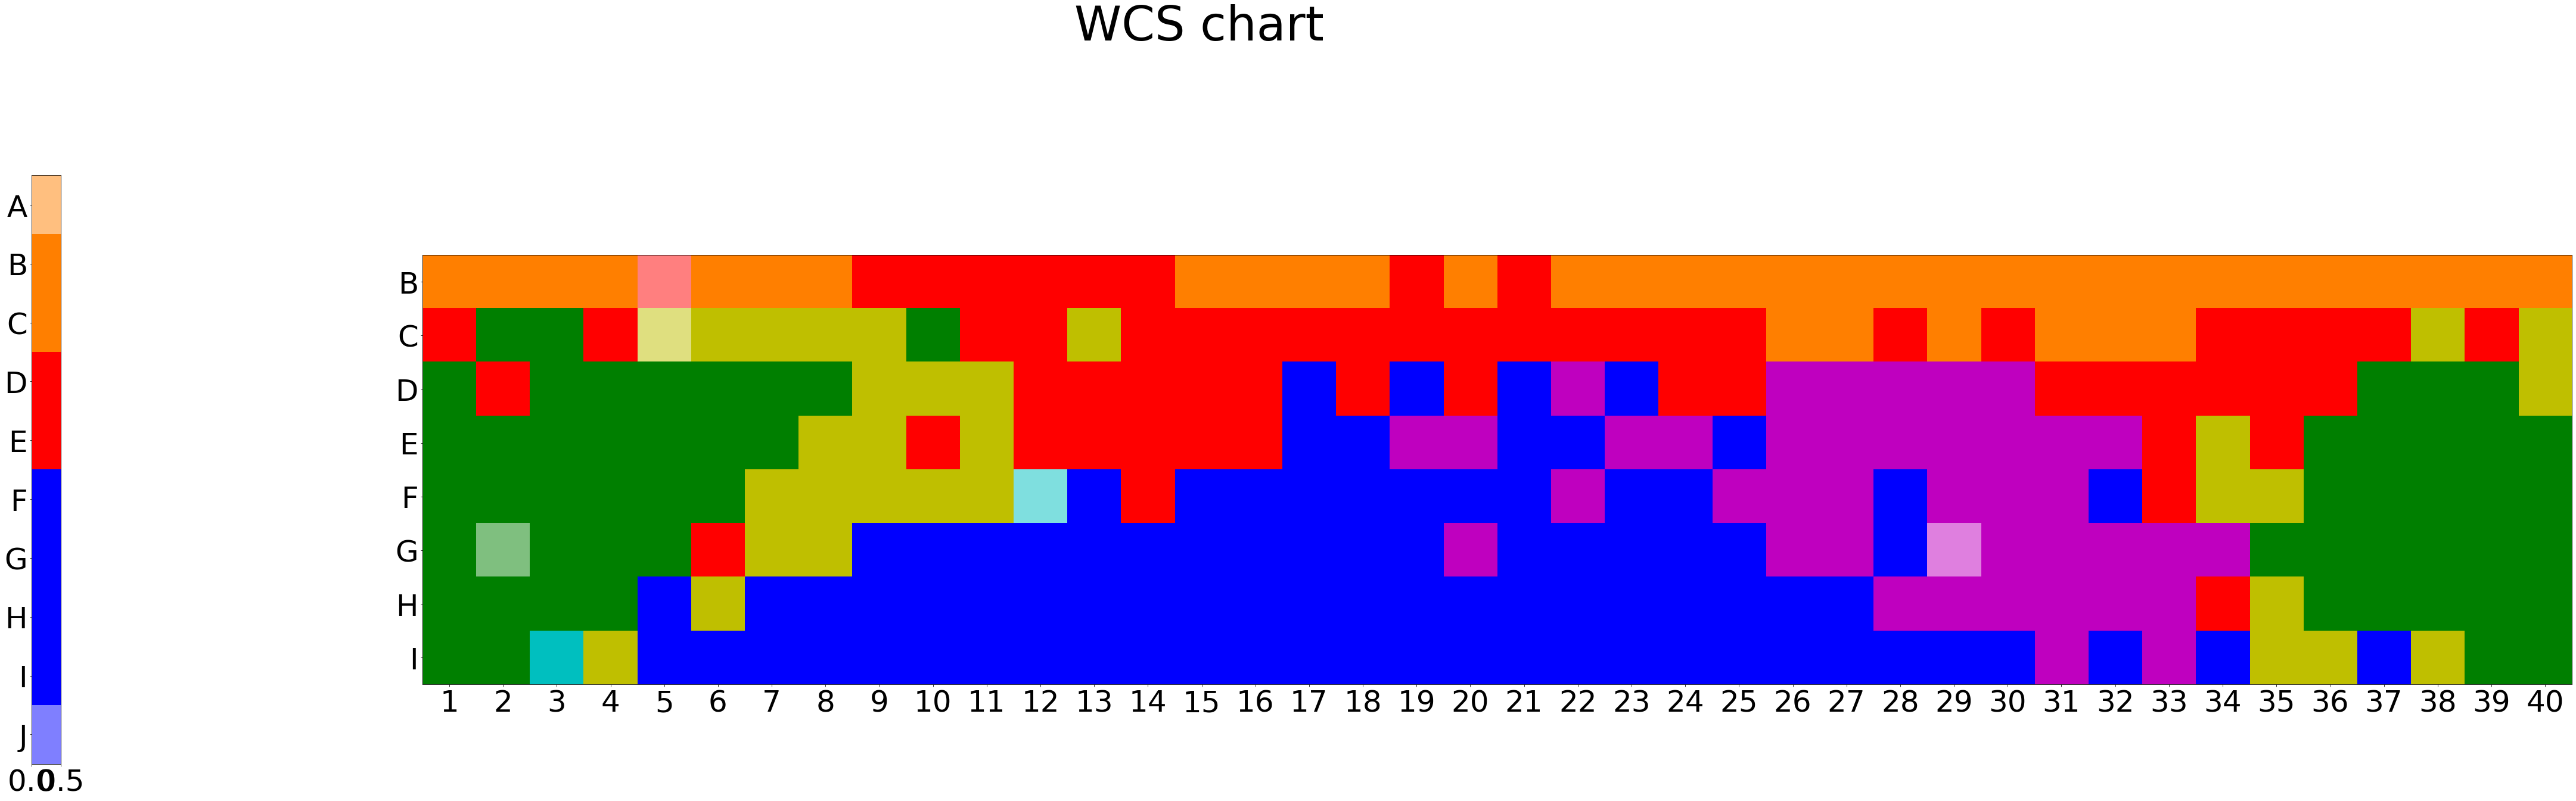

In [35]:
plot_catmap(language_modal_maps[1], language_empirical_foci[1].values())

### 4. Similarity
Define the similarity function for color chips.

In [36]:
def sim(x, y, c=0.001):
    '''
    Returns the similarity between points x and y.
    x and y must be specified as Numpy number arrays of equal length.
    c is a scaling factor that determines how fast similarity decreases for increasingly distant points,
    set by default to be reasonable in Cielab space.
    '''
    return math.exp(-c * (np.linalg.norm(x - y) ** 2))

### 5. Similarity-and-difference model
Compute the predicted foci of the similarity-and-difference model.

In [37]:
language_sad_foci = {} # Dict from language index -> color gloss -> predicted SaD focus for that gloss

for language_index in range(1, 110 + 1):
    color_categories = language_color_categories[language_index]
    
    sad_foci = {}
    
    for gloss, chips in color_categories.items():
        best_chip = None
        best_score = None
        
        for chip in chips:
            score = 0
            
            for other_chip in range(1, 330 + 1):
                similarity = sim(cielabCoord[chip], cielabCoord[other_chip])
                if other_chip in chips:
                    score += similarity # measure of similarity
                else:
                    score += (1 - similarity) # measure of dissimilarity 
            
            if best_chip is None or best_score < score:
                best_chip = chip
                best_score = score
        
        sad_foci[gloss] = best_chip
    
    language_sad_foci[language_index] = sad_foci

### 6. Prototype model
Compute the predicted foci of the prototype model.

In [38]:
language_prototype_foci = {} # Dict from language index -> color gloss -> predicted prototype focus for that gloss

for language_index in range(1, 110 + 1):
    color_categories = language_color_categories[language_index]
    
    prototype_foci = {}
    
    for gloss, chips in color_categories.items():
        best_chip = None
        best_score = None
        
        for chip in chips:
            score = sum(sim(cielabCoord[chip], cielabCoord[other_chip]) for other_chip in chips)
            
            if best_chip is None or best_score < score:
                best_chip = chip
                best_score = score
        
        prototype_foci[gloss] = best_chip
    
    language_prototype_foci[language_index] = prototype_foci

### 7. Random models
Compute the "predicted" foci of the random (control) models.

In [39]:
# List of 20 dicts, each of which is from language index -> color gloss -> one "predicted" random focus for that gloss
all_random_foci = [{} for _ in range(20)]

for language_random_foci in all_random_foci:
    for language_index in range(1, 110 + 1):
        random_foci = {gloss: random.choice(chips) for gloss, chips in language_color_categories[language_index].items()}
        language_random_foci[language_index] = random_foci

### 8. Model accuracies
Compute the accuracies of each model for each language, and on average across all languages.

In [40]:
def model_accuracy(empirical_foci, predicted_foci, c=0.001):
    '''
    Returns the accuracy of the specified predicted foci relative to the specified empirical foci
    - that is, the average similarity between each empirical focus and its corresponding predicted focus.
    empirical_foci and predicted_foci are both dicts from color gloss -> chip index of focus location.
    c is the scaling factor of the similarity calculations, set by default to be reasonable in Cielab space.
    '''
    avg_sim = 0
    for gloss, chip in empirical_foci.items():
        avg_sim += sim(cielabCoord[chip], cielabCoord[predicted_foci[gloss]], c)
    avg_sim /= len(empirical_foci)
    return avg_sim

language_sad_accuracies = {i: model_accuracy(language_empirical_foci[i], language_sad_foci[i])
                           for i in range(1, 110 + 1)}
avg_sad_accuracy = sum(language_sad_accuracies.values()) / 110
print('Average similarity-and-difference model accuracy:', avg_sad_accuracy)

language_prototype_accuracies = {i: model_accuracy(language_empirical_foci[i], language_prototype_foci[i])
                                 for i in range(1, 110 + 1)}
avg_prototype_accuracy = sum(language_prototype_accuracies.values()) / 110
print('Average prototype model accuracy:', avg_prototype_accuracy)

all_random_accuracies = [{i: model_accuracy(language_empirical_foci[i], all_random_foci[j][i])
                          for i in range(1, 110 + 1)} for j in range(20)]
language_avg_random_accuracies = {i: (sum(all_random_accuracies[j][i] for j in range(20)) / 20)
                                  for i in range(1, 110 + 1)}
avg_random_accuracy = sum(language_avg_random_accuracies.values()) / 110
print('Average random model accuracy:', avg_random_accuracy)

Average similarity-and-difference model accuracy: 0.7149671231551411
Average prototype model accuracy: 0.649964651413464
Average random model accuracy: 0.4925294512063325


### 9. Plot distributions
Plot distributions (i.e. histogram and box-plot), for each model, of accuracy values for every language.

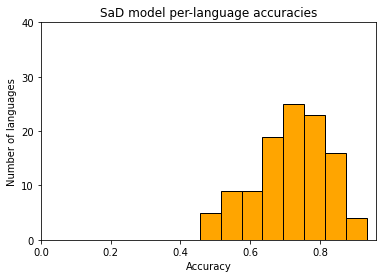

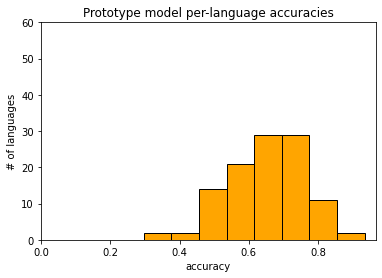

In [41]:
# SaD model histogram

plt.hist(language_sad_accuracies.values(), bins=8, color=['orange'], edgecolor='k')
plt.xticks(np.arange(0, 1, step=0.2), fontsize=10)
plt.yticks(np.arange(0, 50, step=10), fontsize=10)
plt.title('SaD model per-language accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Number of languages')
plt.show()

# Prototype model histogram

plt.hist(language_prototype_accuracies.values(), bins=8, color=['orange'], edgecolor='k')
plt.xticks(np.arange(0, 1, step=0.2), fontsize=10)
plt.yticks(np.arange(0, 70, step=10), fontsize=10)
plt.title('Prototype model per-language accuracies')
plt.xlabel("accuracy")
plt.ylabel('# of languages')
plt.show()

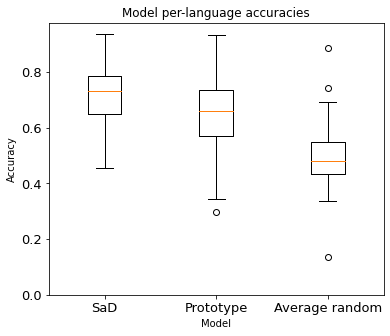

In [42]:
# Create data to plot
data_to_plot = [list(language_sad_accuracies.values()),
                list(language_prototype_accuracies.values()),
                list(language_avg_random_accuracies.values())]
fig = plt.figure(1, figsize=(6, 5))
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)
ax.set_title('Model per-language accuracies')
ax.set(xlabel='Model', ylabel='Accuracy')
ax.set_xticklabels(['SaD', 'Prototype', 'Average random'])
ax.set_yticks(np.arange(0, 1, step=0.2))
ax.tick_params(axis = 'both', which = 'major', labelsize = 13)

### 10. Analysis of results 
Discuss why the distributions look the way they do and why any outliers are unusual.

#### Analysis 1 - correlation between accuracy using SaD model and average accuracy using random models
By comparing the 5 languages with the highest SaD accuracy with the 5 languages with the lowest SaD accuracy, we can notice that the modal maps of the latter tend to appear more "random" than those of the former. We can perhaps hypothesize that there is some negative correlation between SaD accuracy and random accuracy - that is, the higher the SaD accuracy of a language, the lower the random accuracy.

In [43]:
sorted_sad_accuracies = [x for x in sorted(language_sad_accuracies.items(), key=lambda x: x[1])] # sorted ascending

Language index: 70 - Accuracy: 0.9361368843874189
Language index: 48 - Accuracy: 0.9031573087955603
Language index: 28 - Accuracy: 0.8943026925898562
Language index: 72 - Accuracy: 0.8842054325947935
Language index: 34 - Accuracy: 0.8617642612809021


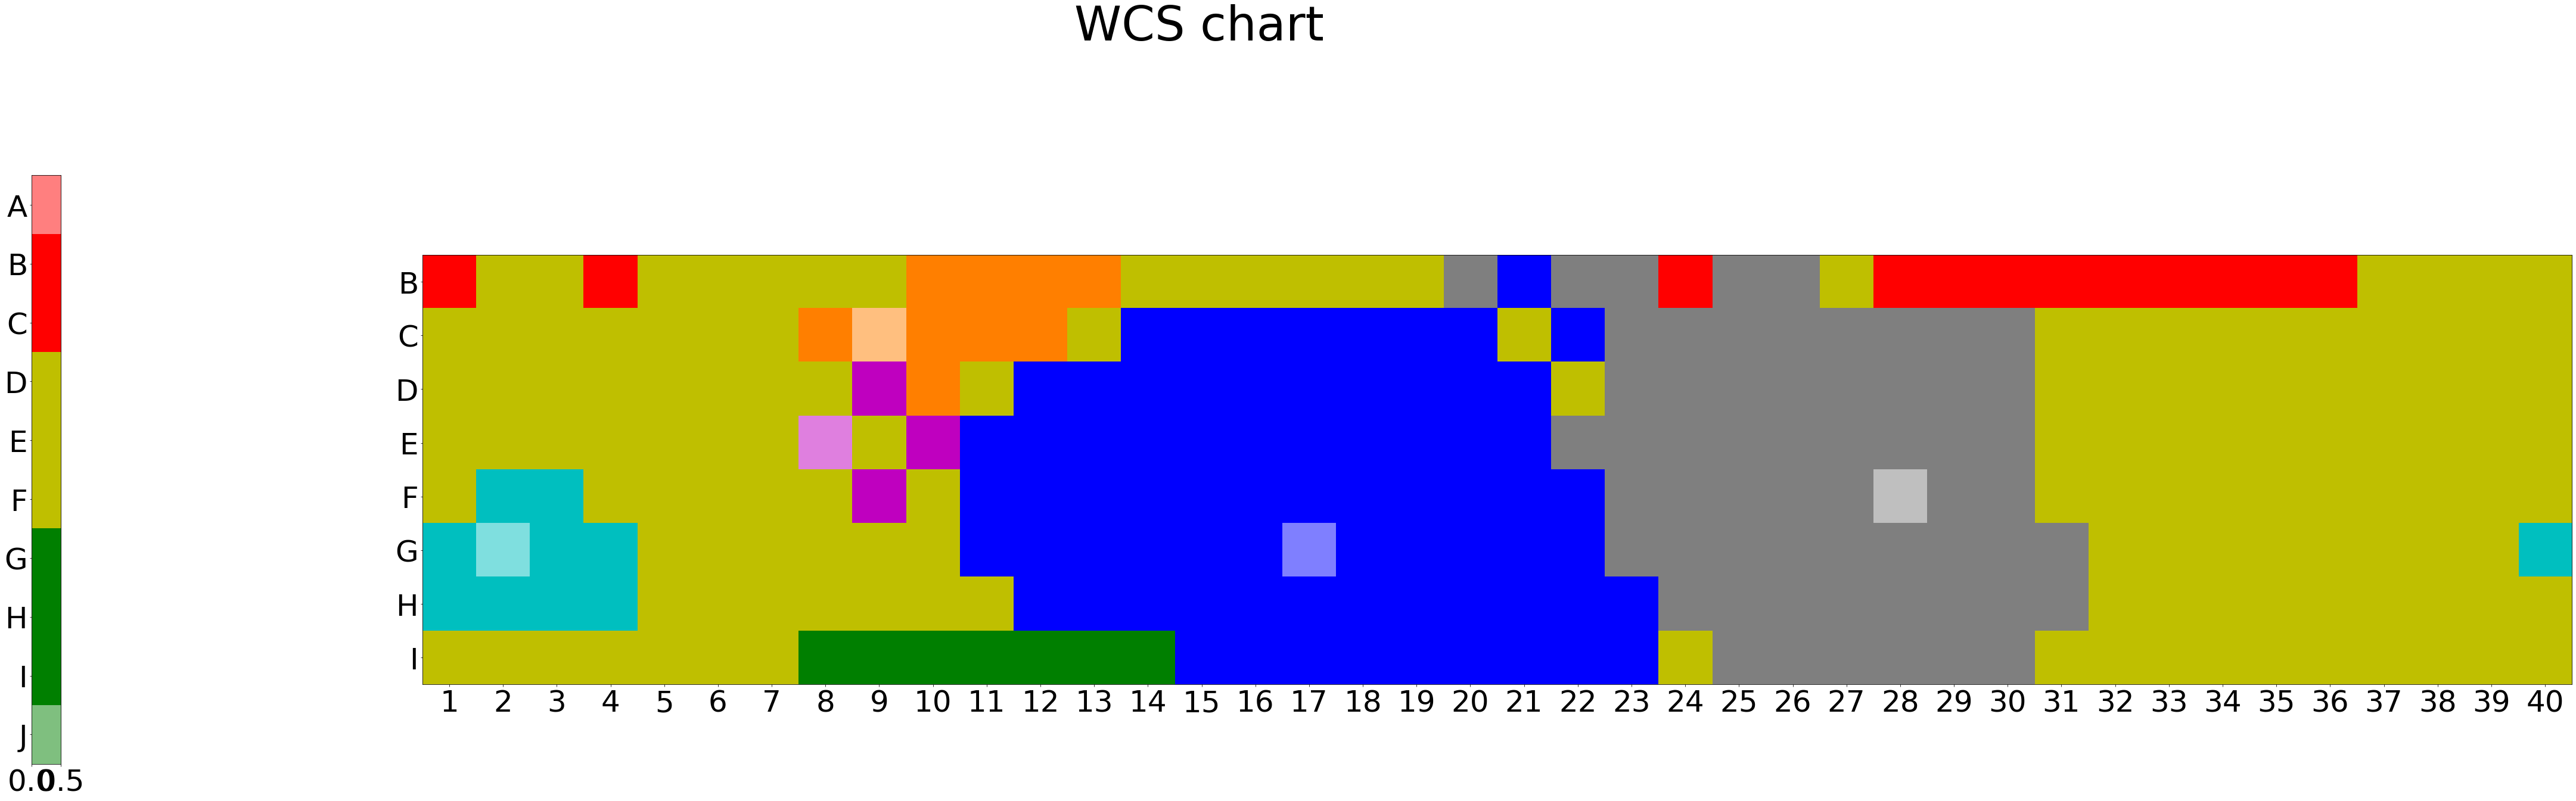

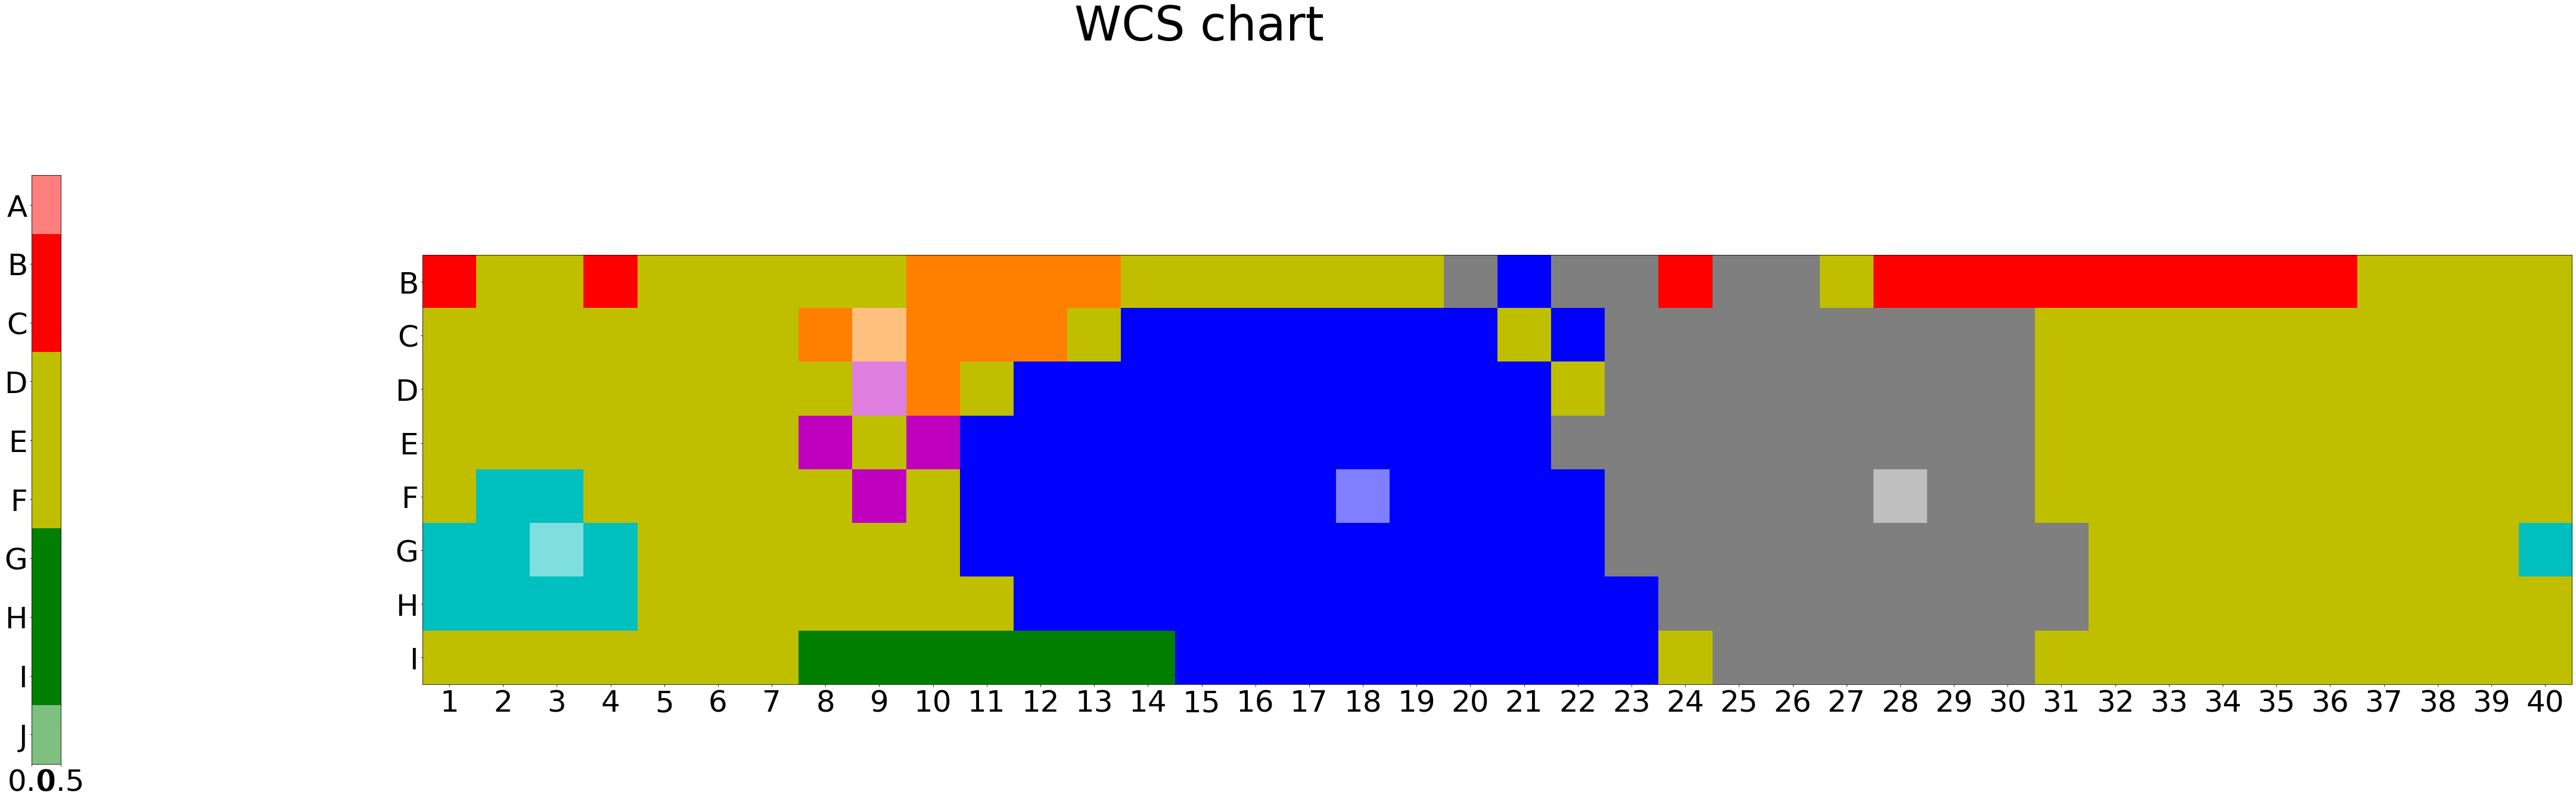

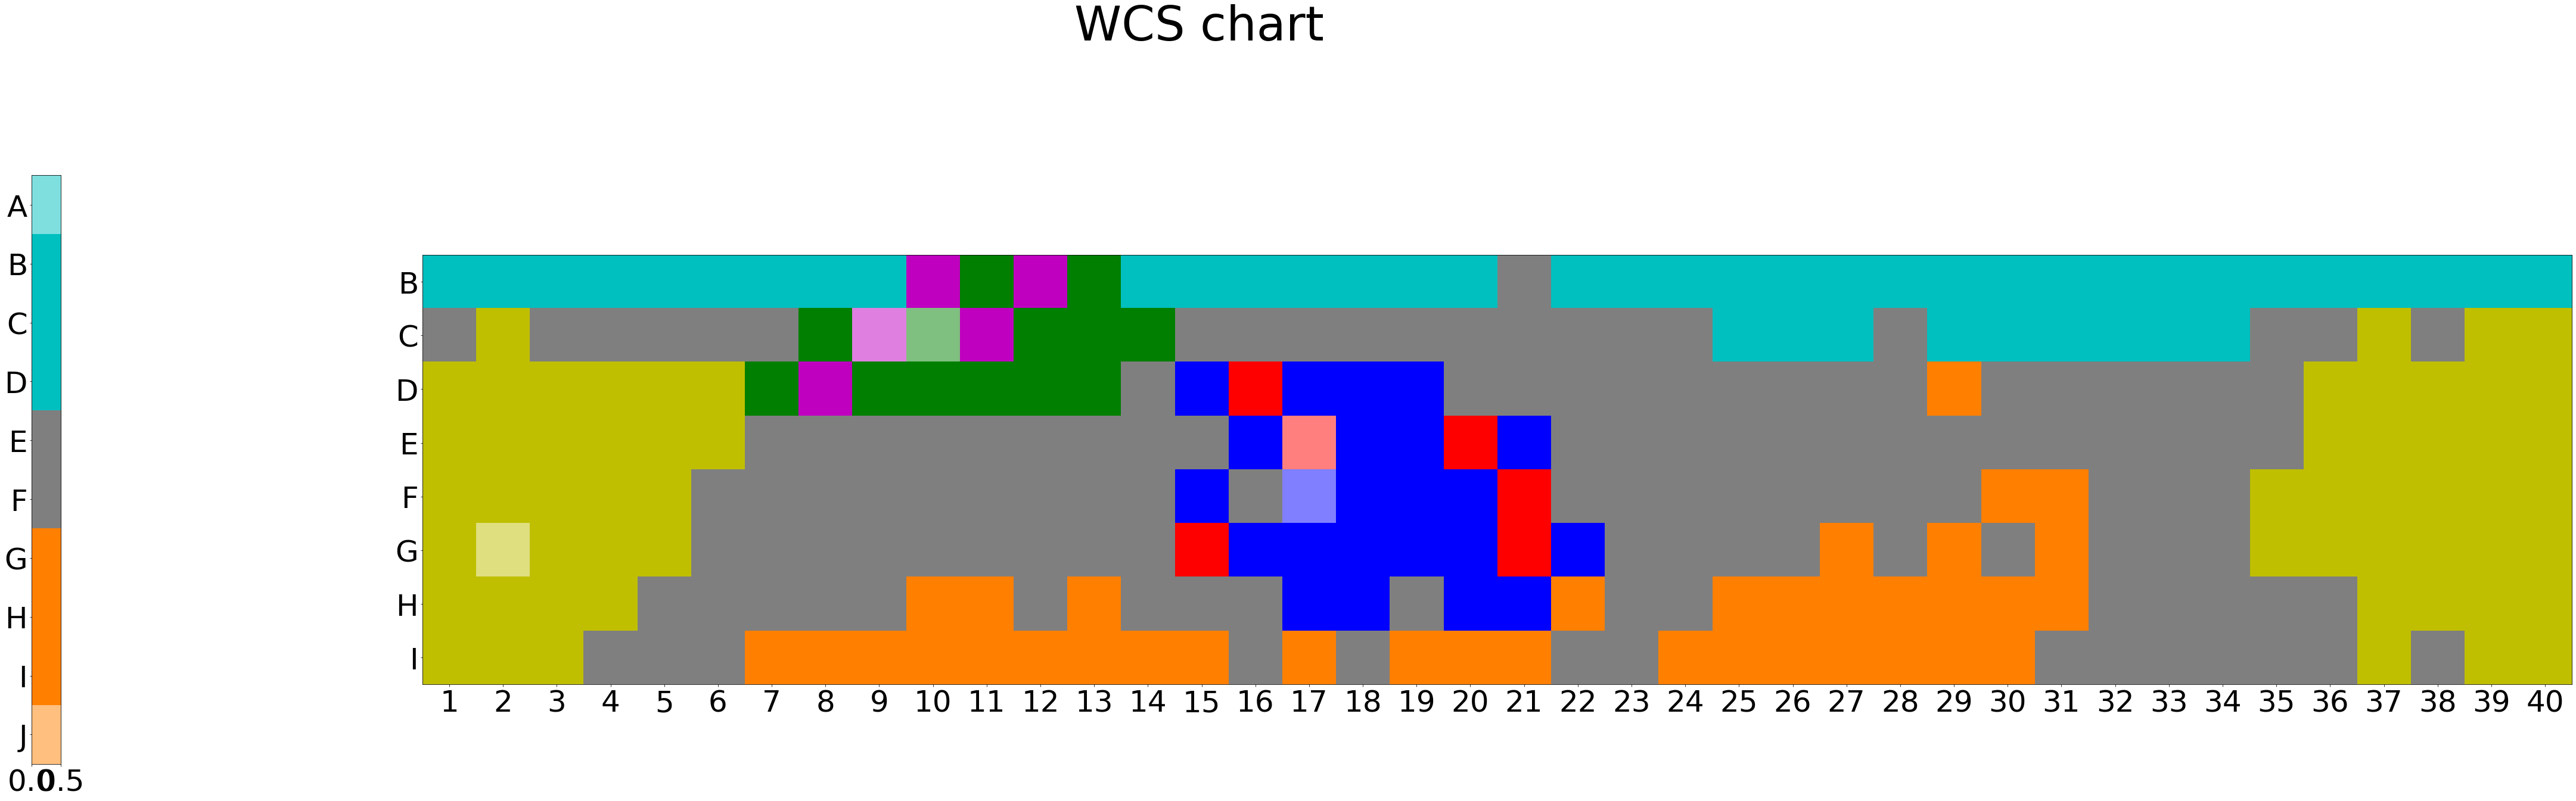

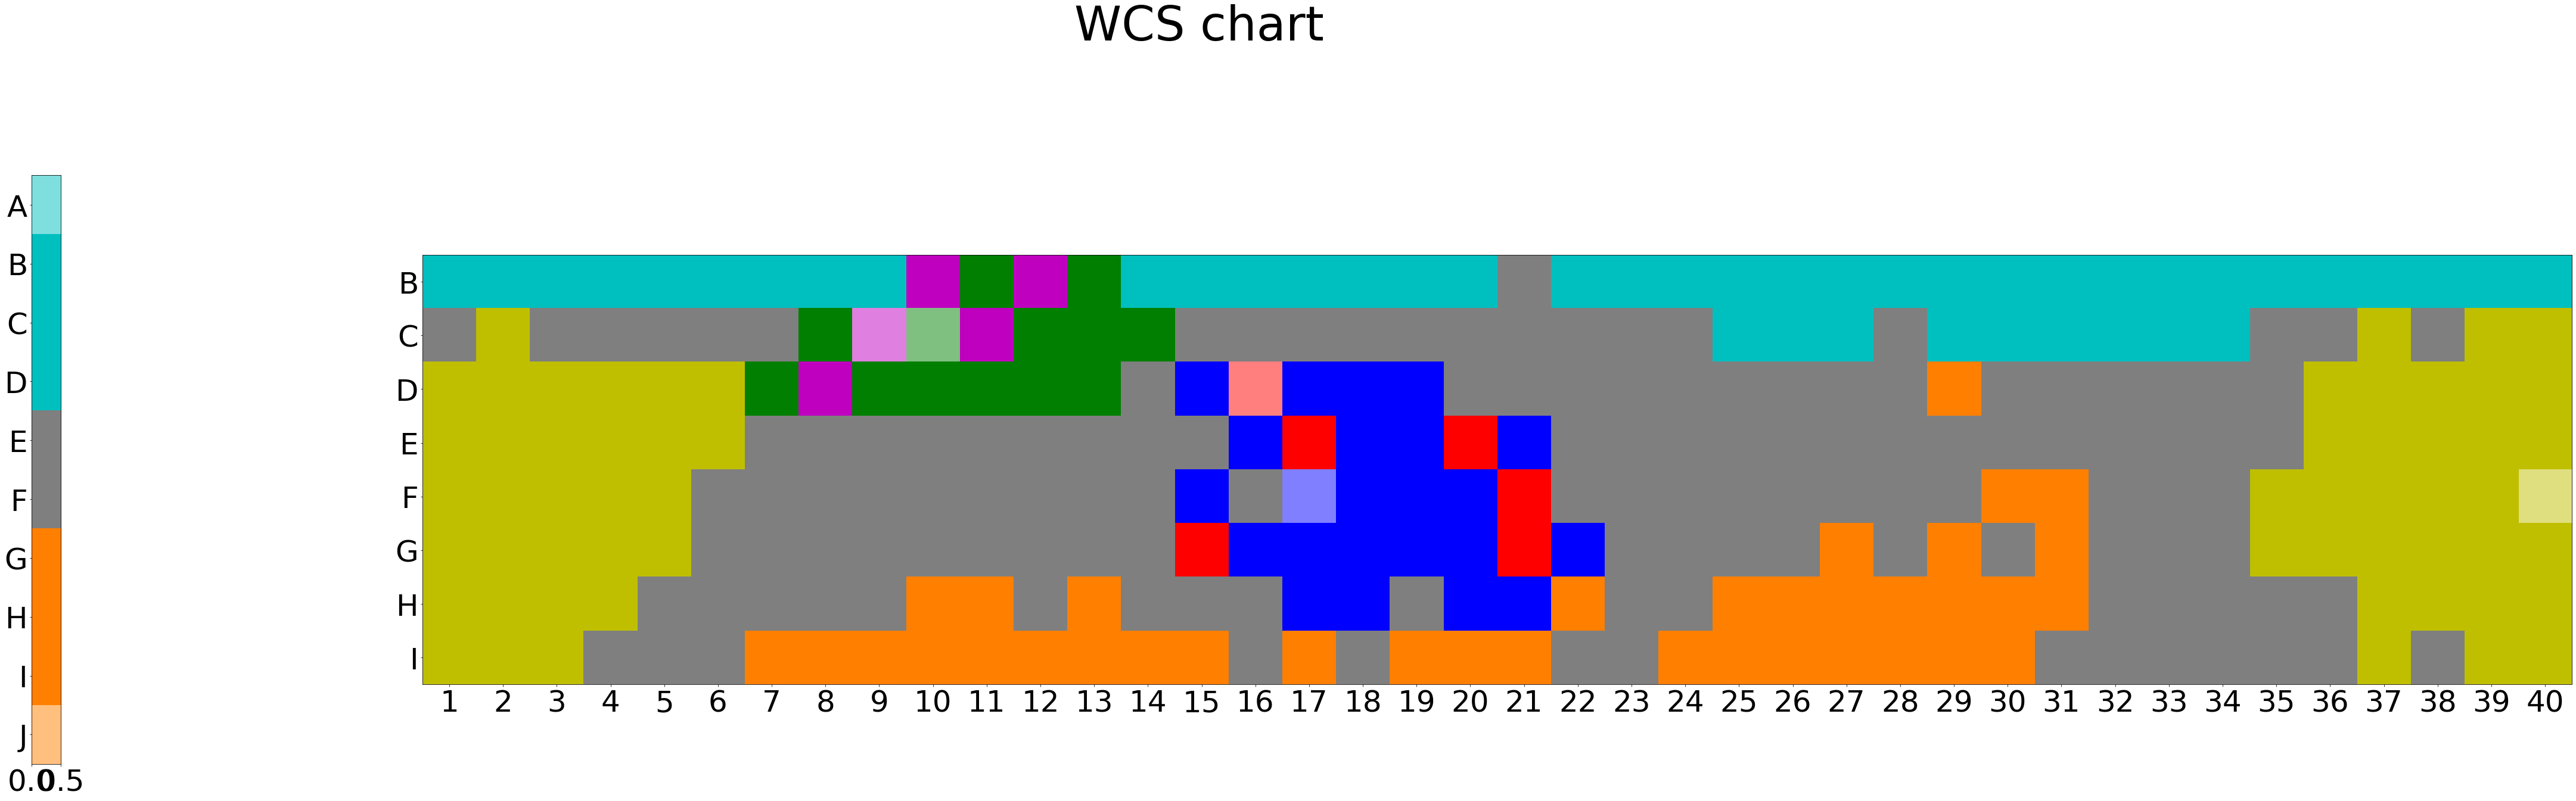

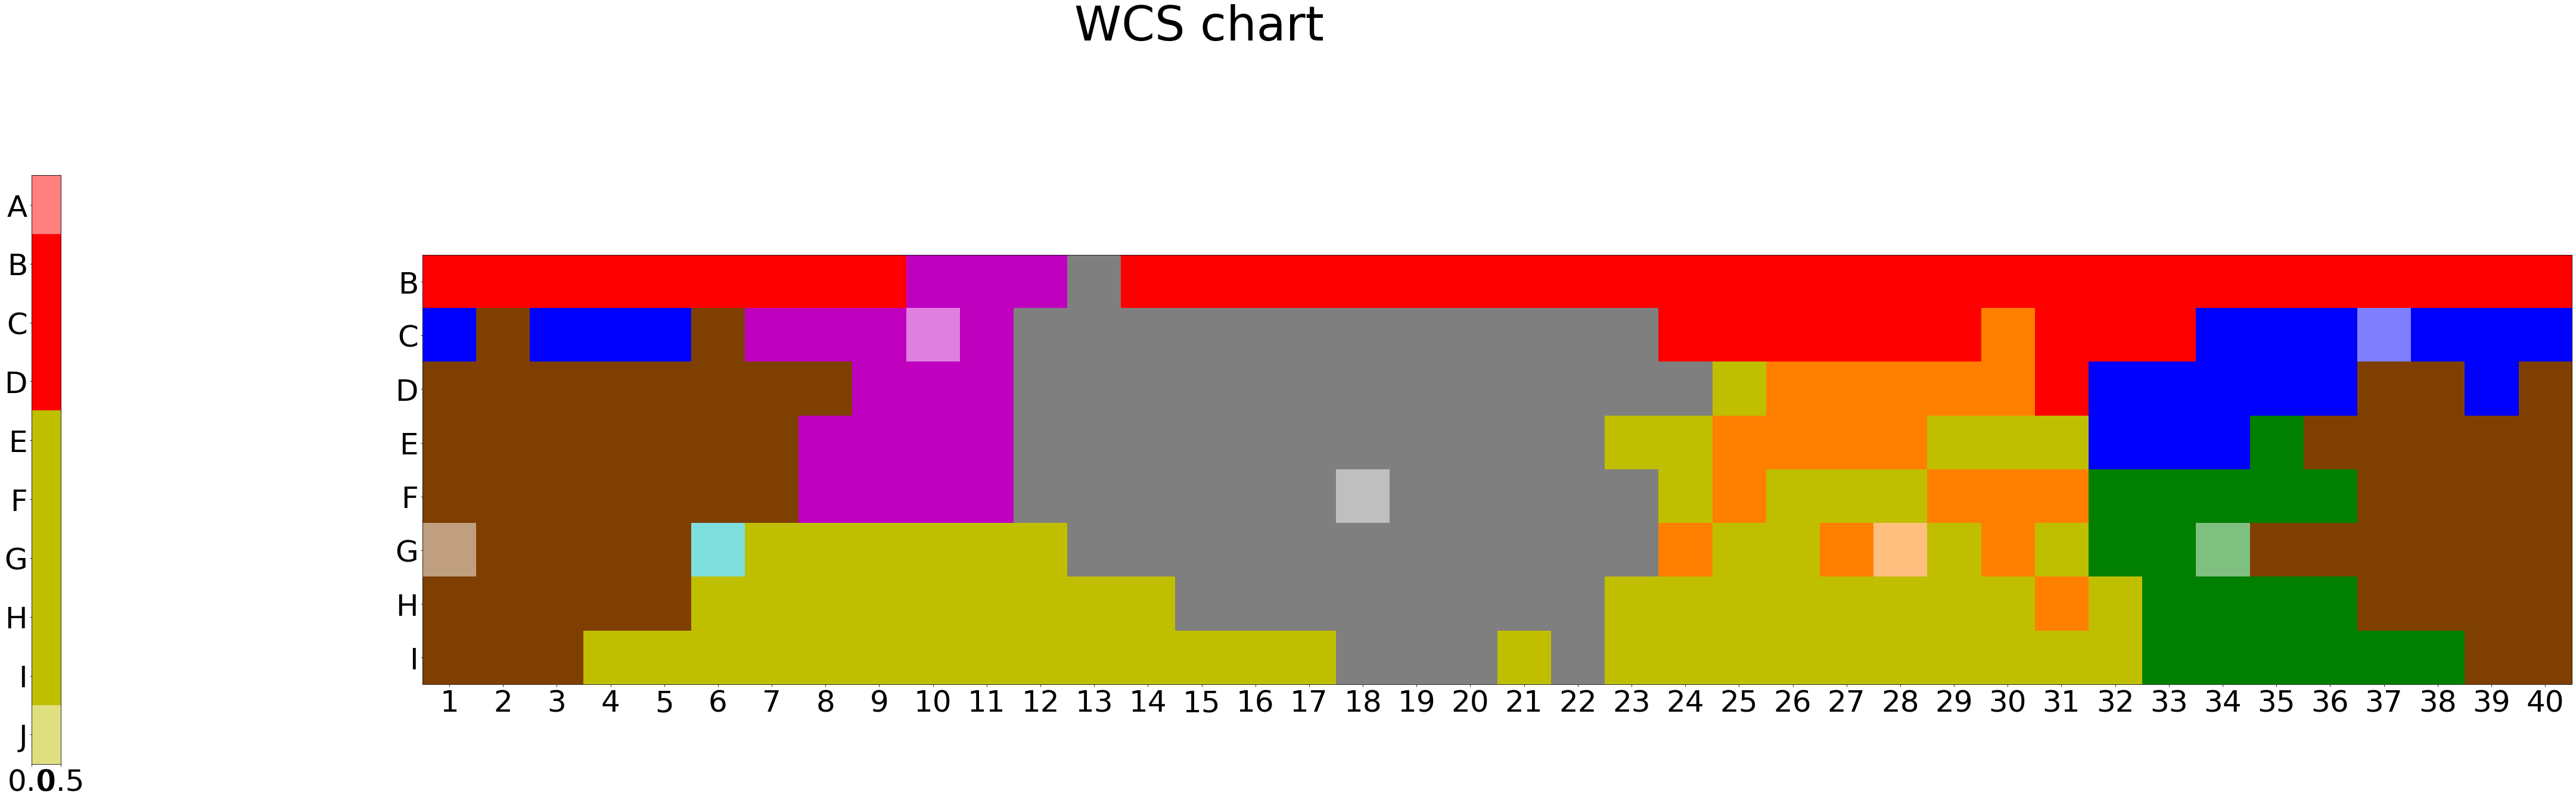

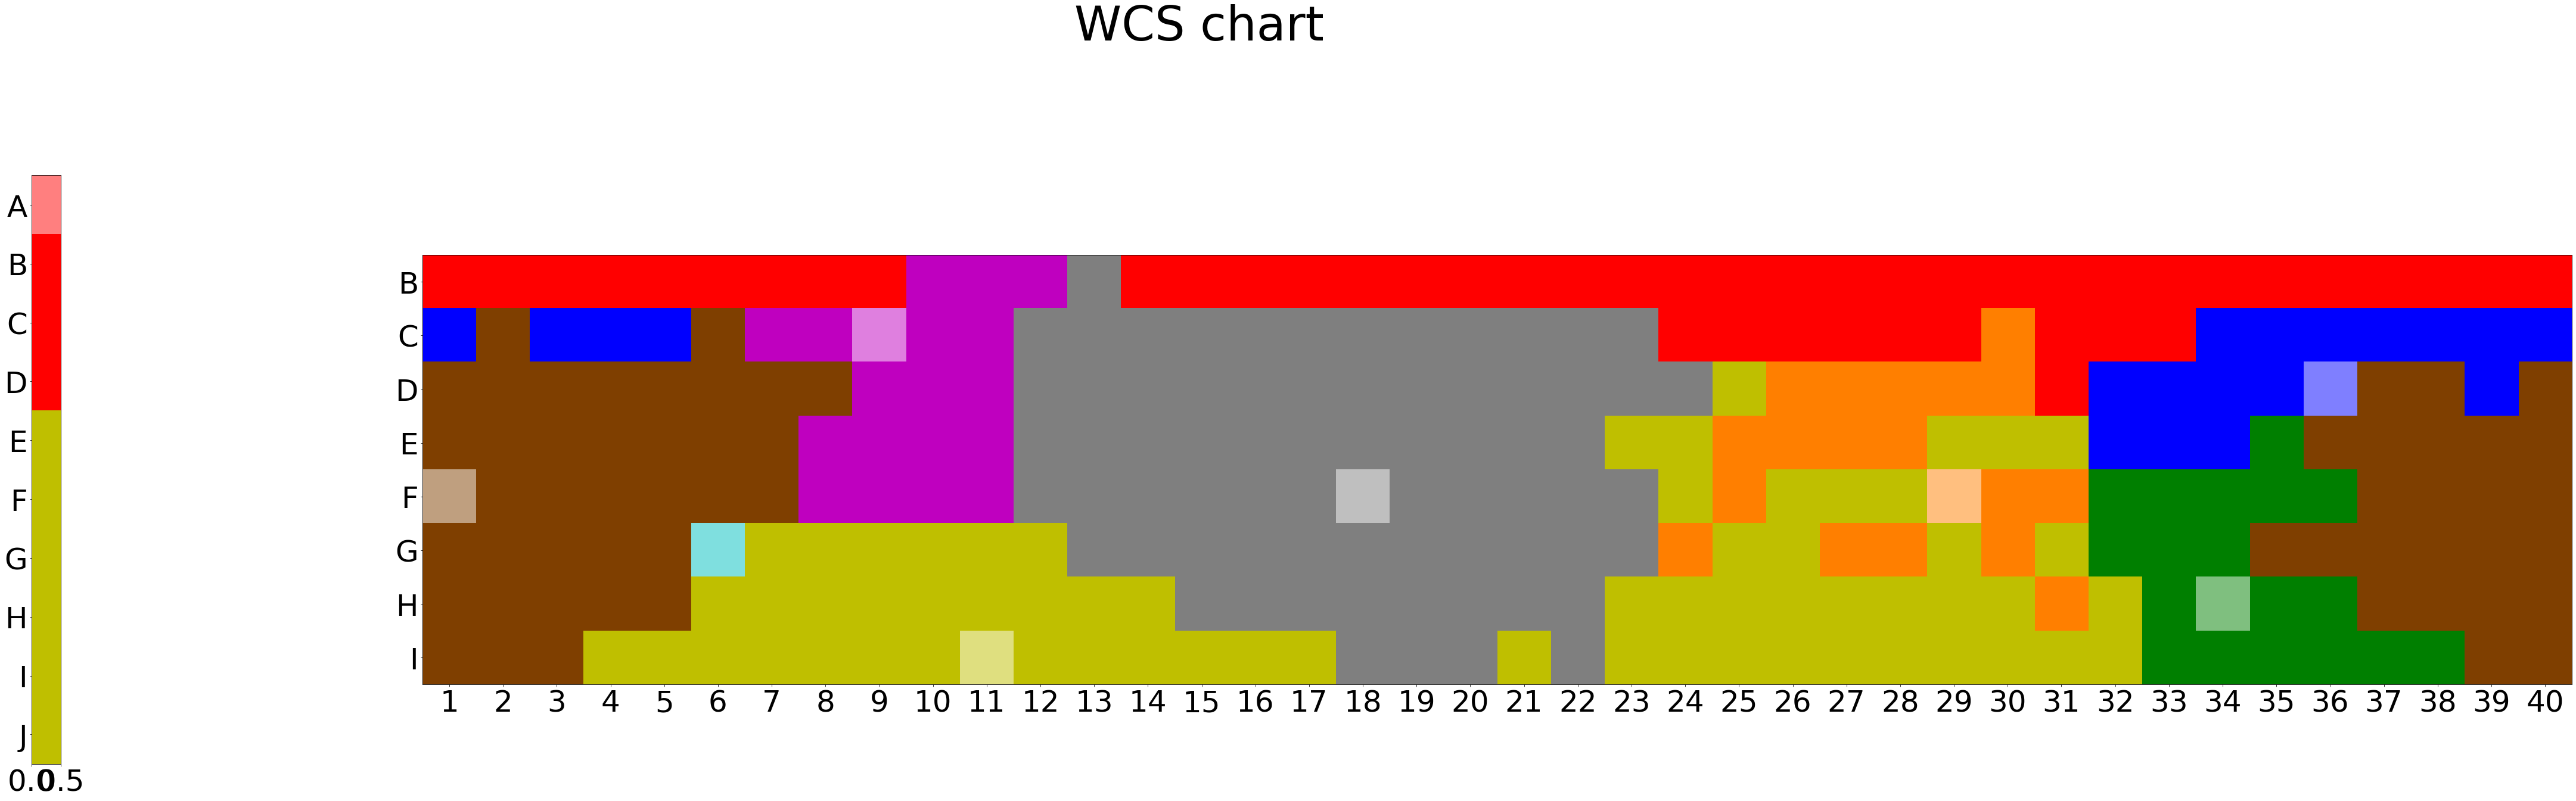

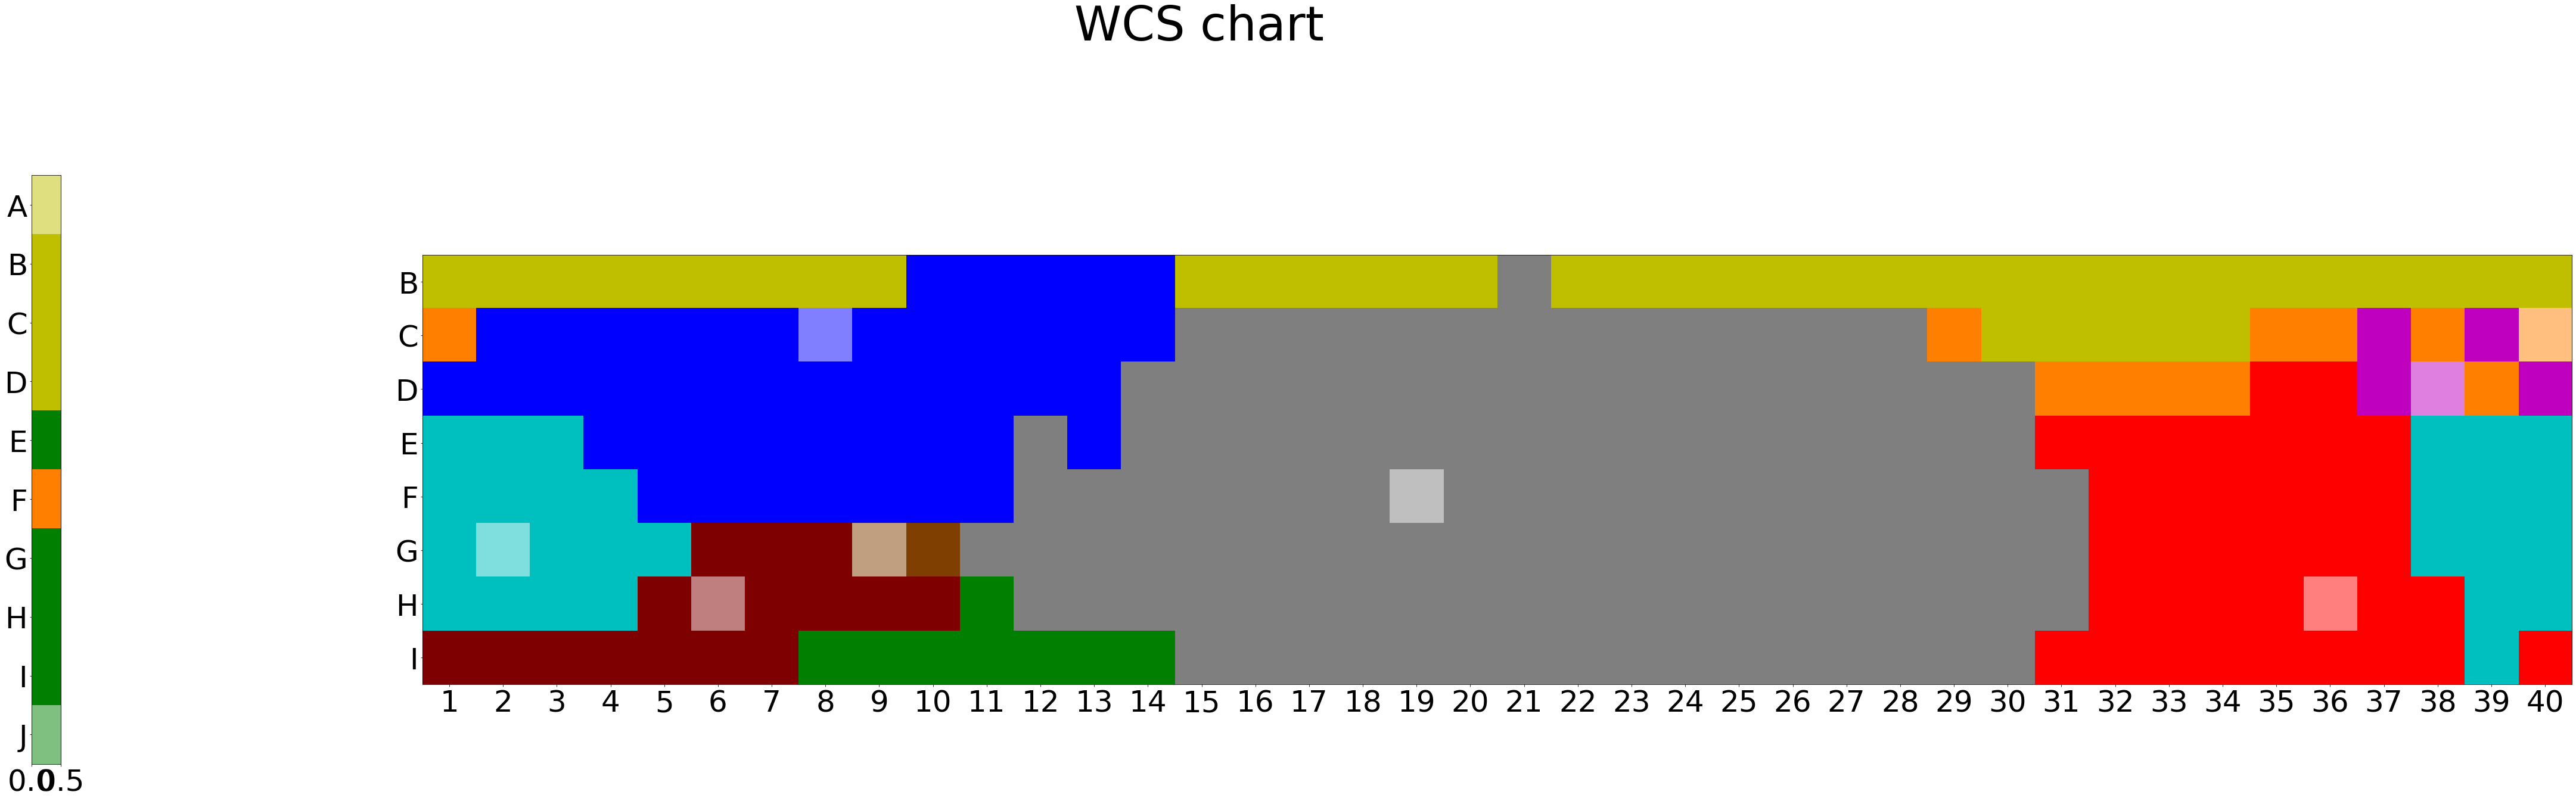

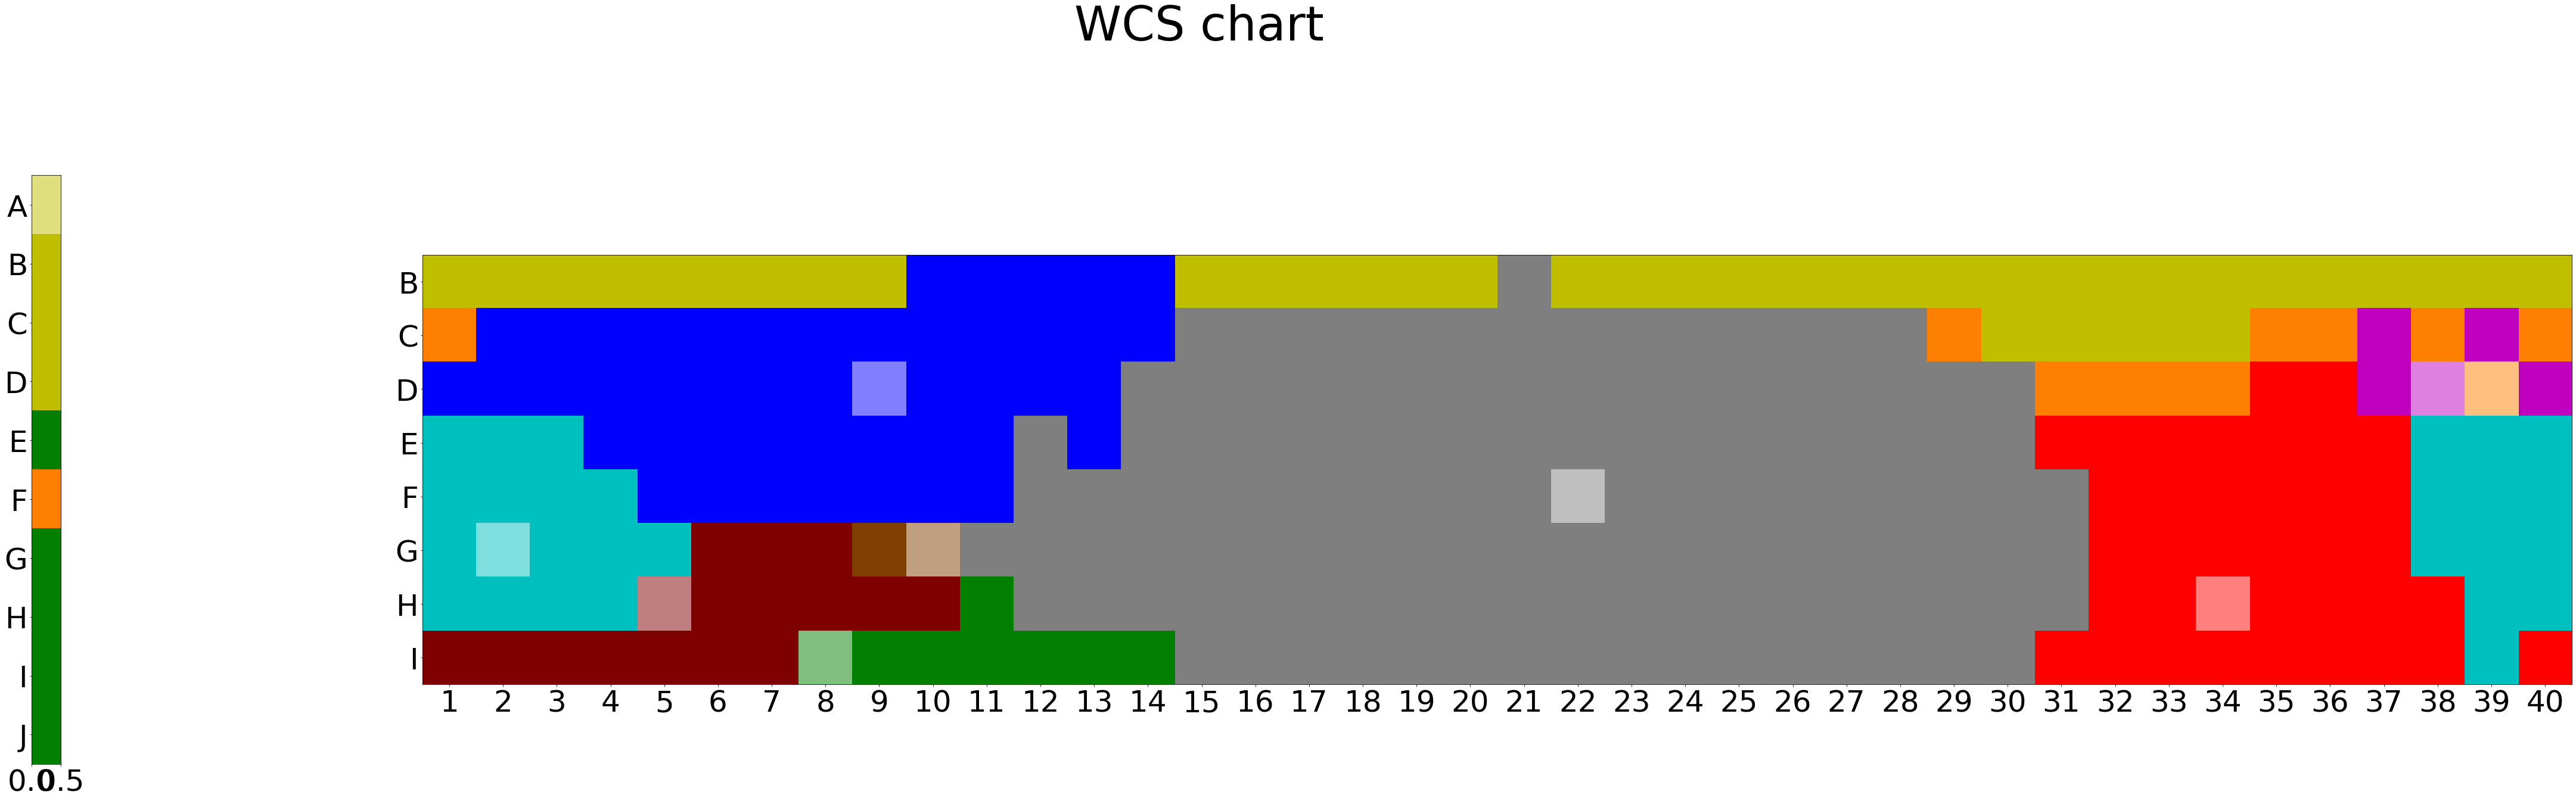

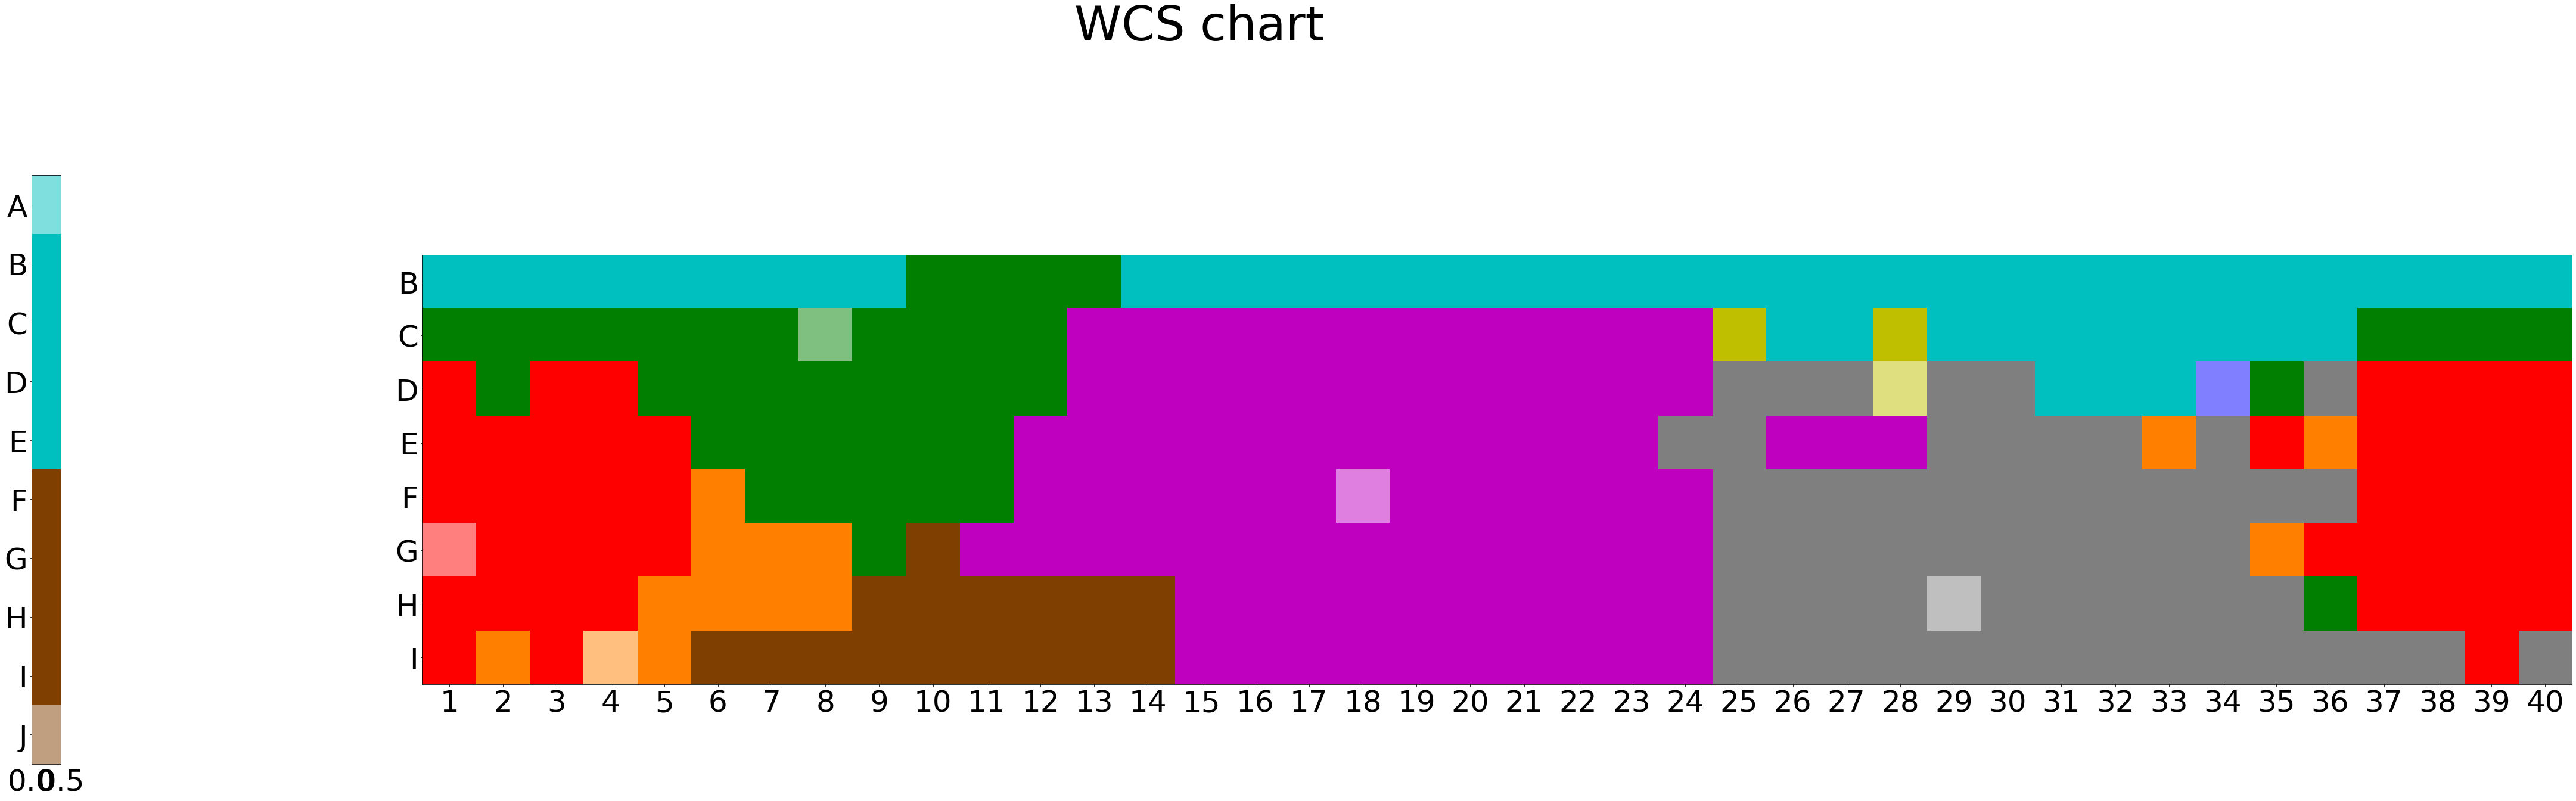

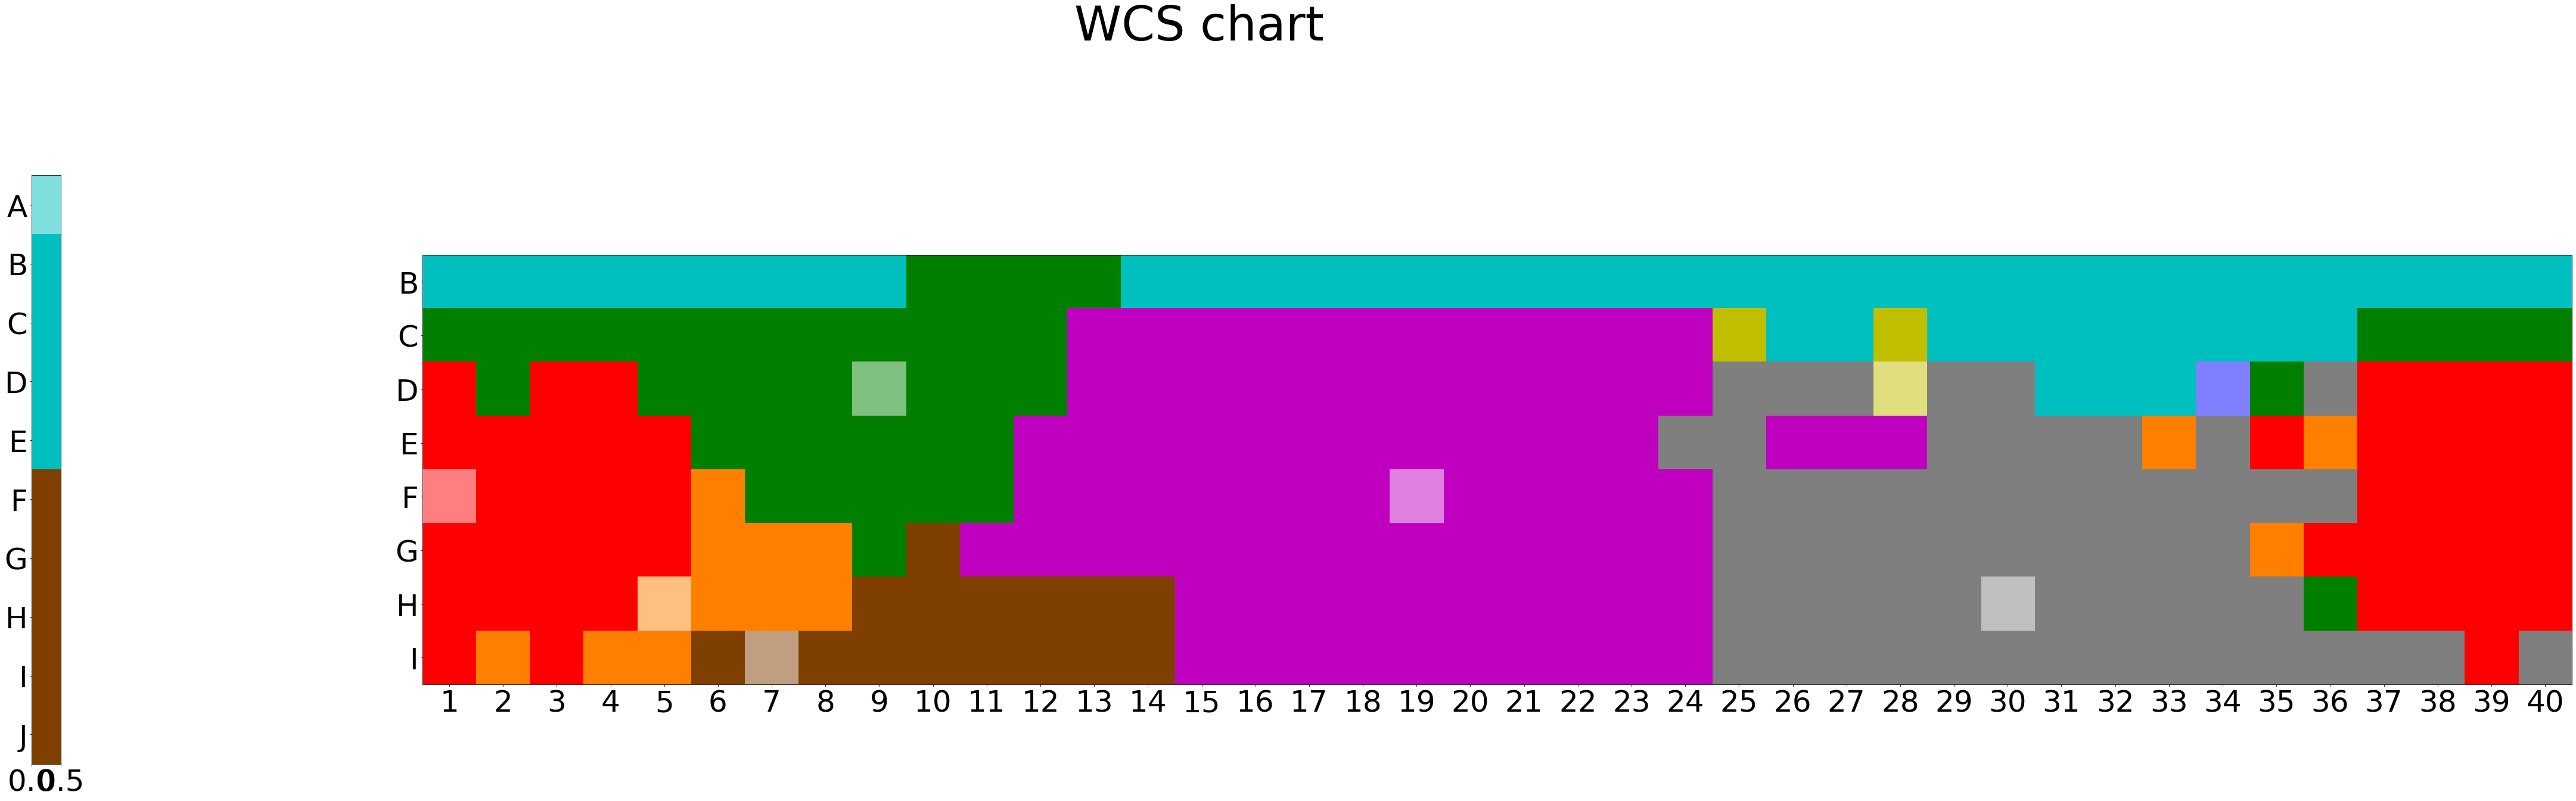

In [44]:
# 5 languages with highest accuracy for SaD model
for i in range(5):
    language_index = sorted_sad_accuracies[110 - 1 - i][0]
    print('Language index:', language_index, '- Accuracy:', sorted_sad_accuracies[110 - 1 - i][1])
    catmap = language_modal_maps[language_index]
    terms = list(catmap.values())
    rgbs = generate_rgb_values(terms)
    plot_catmap(catmap, language_empirical_foci[language_index].values(), rgbs)
    plot_catmap(catmap, [language_sad_foci[language_index][gloss] for gloss in language_empirical_foci[language_index]], rgbs)

Language index: 10 - Accuracy: 0.45491617932391165
Language index: 86 - Accuracy: 0.48586366025083483
Language index: 62 - Accuracy: 0.49736262144142823
Language index: 14 - Accuracy: 0.5024530313885341
Language index: 20 - Accuracy: 0.5082559752125102


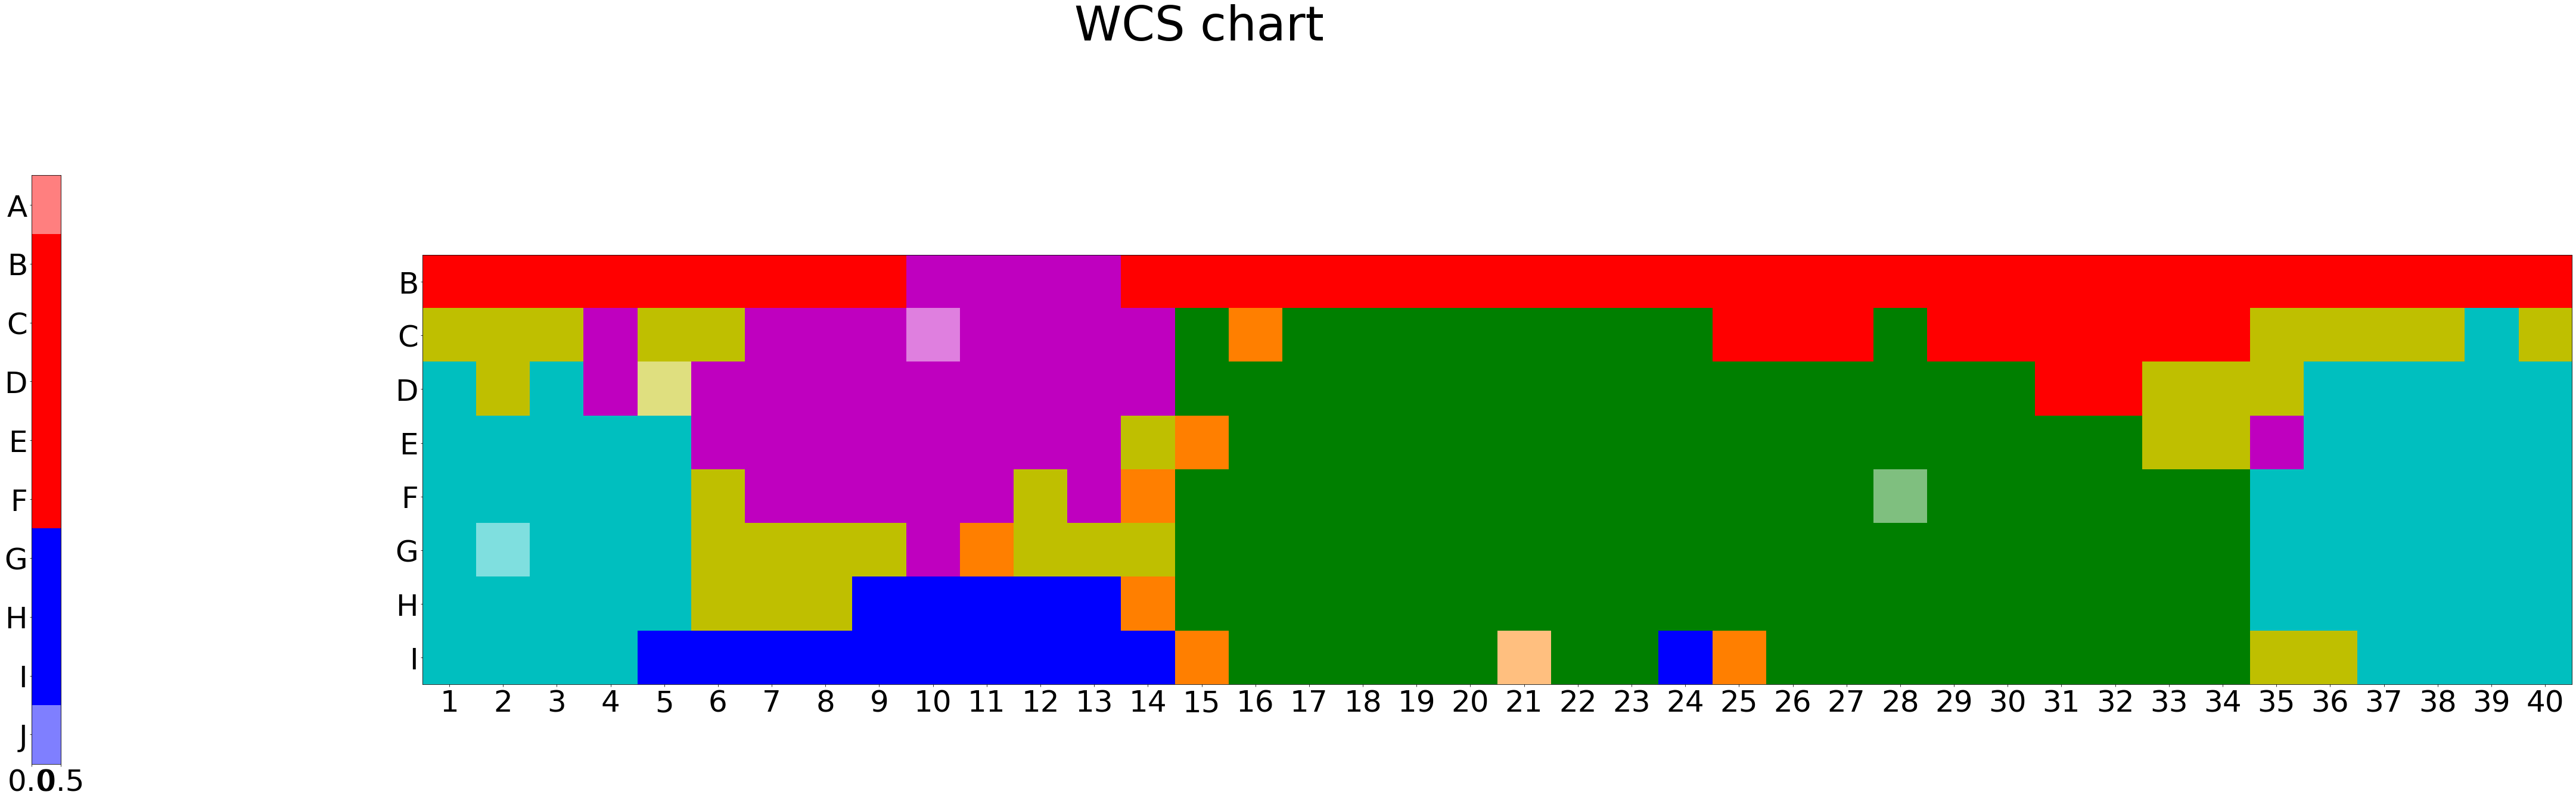

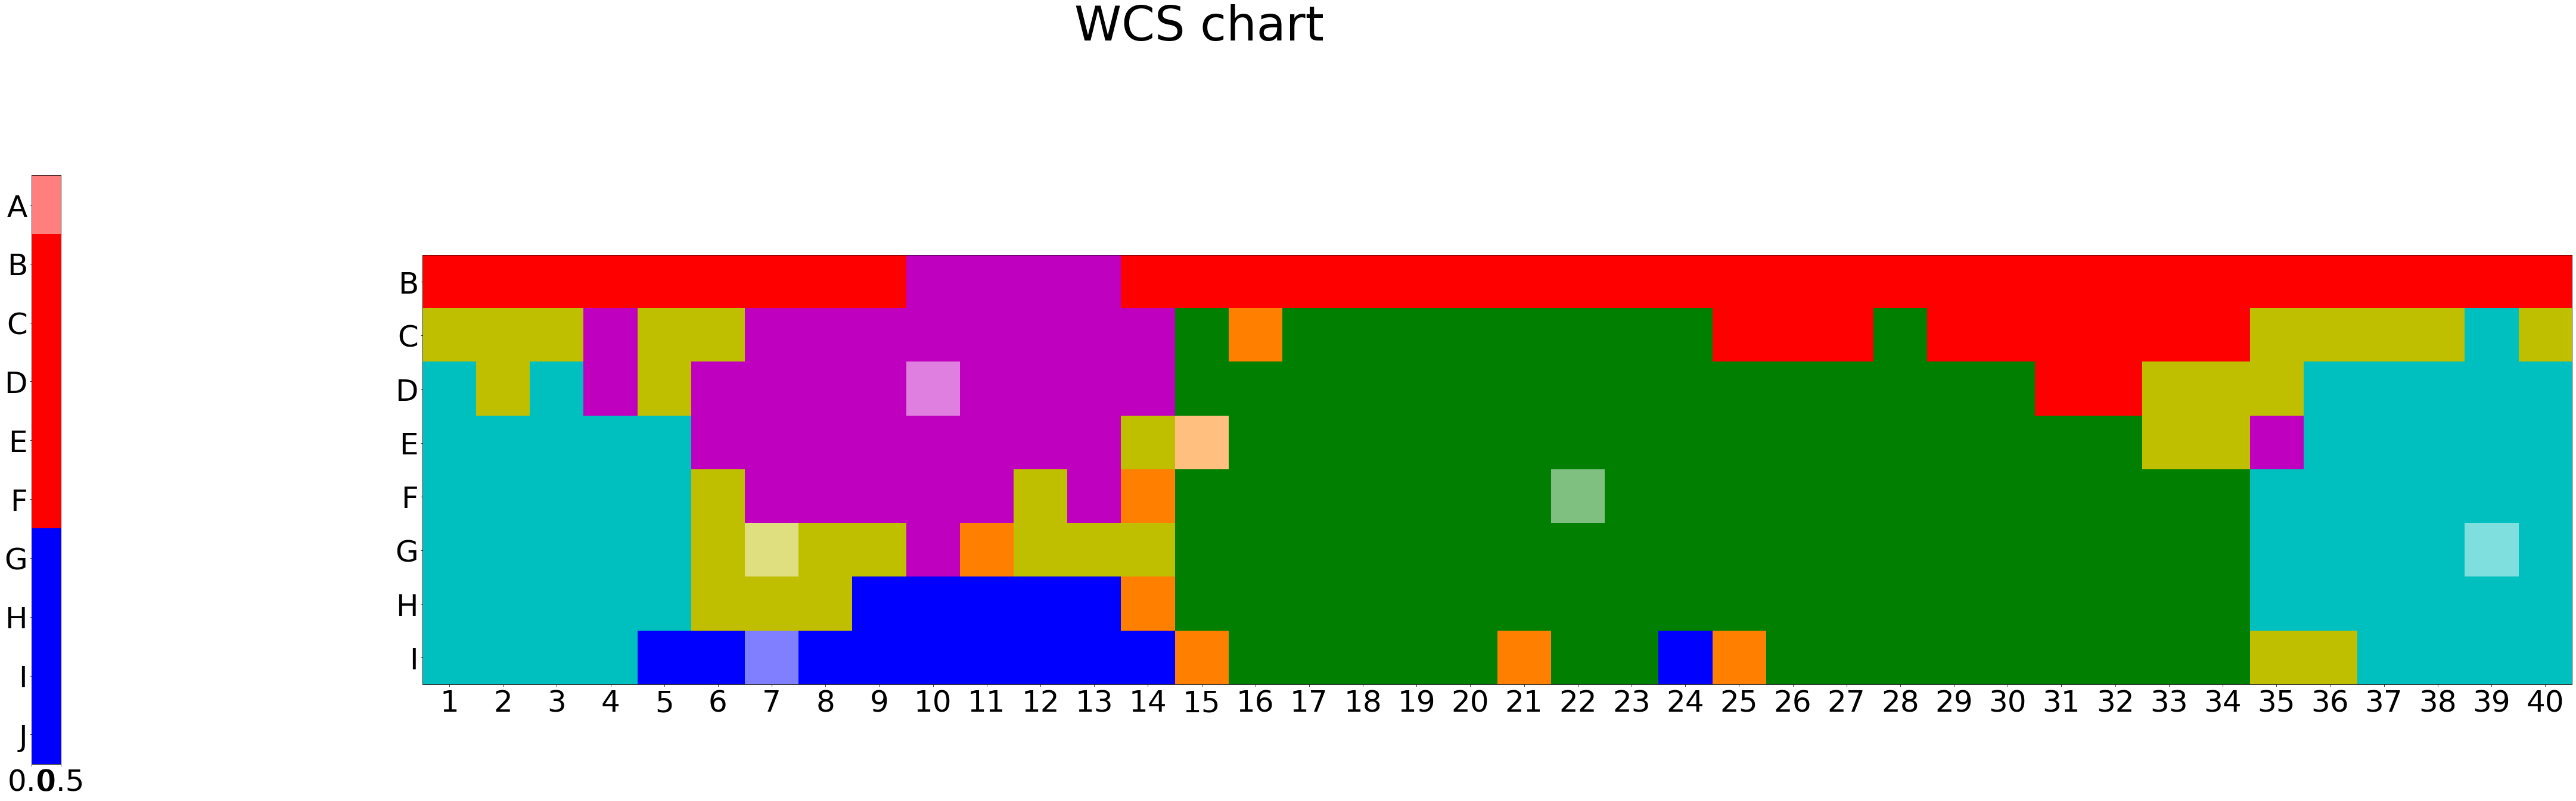

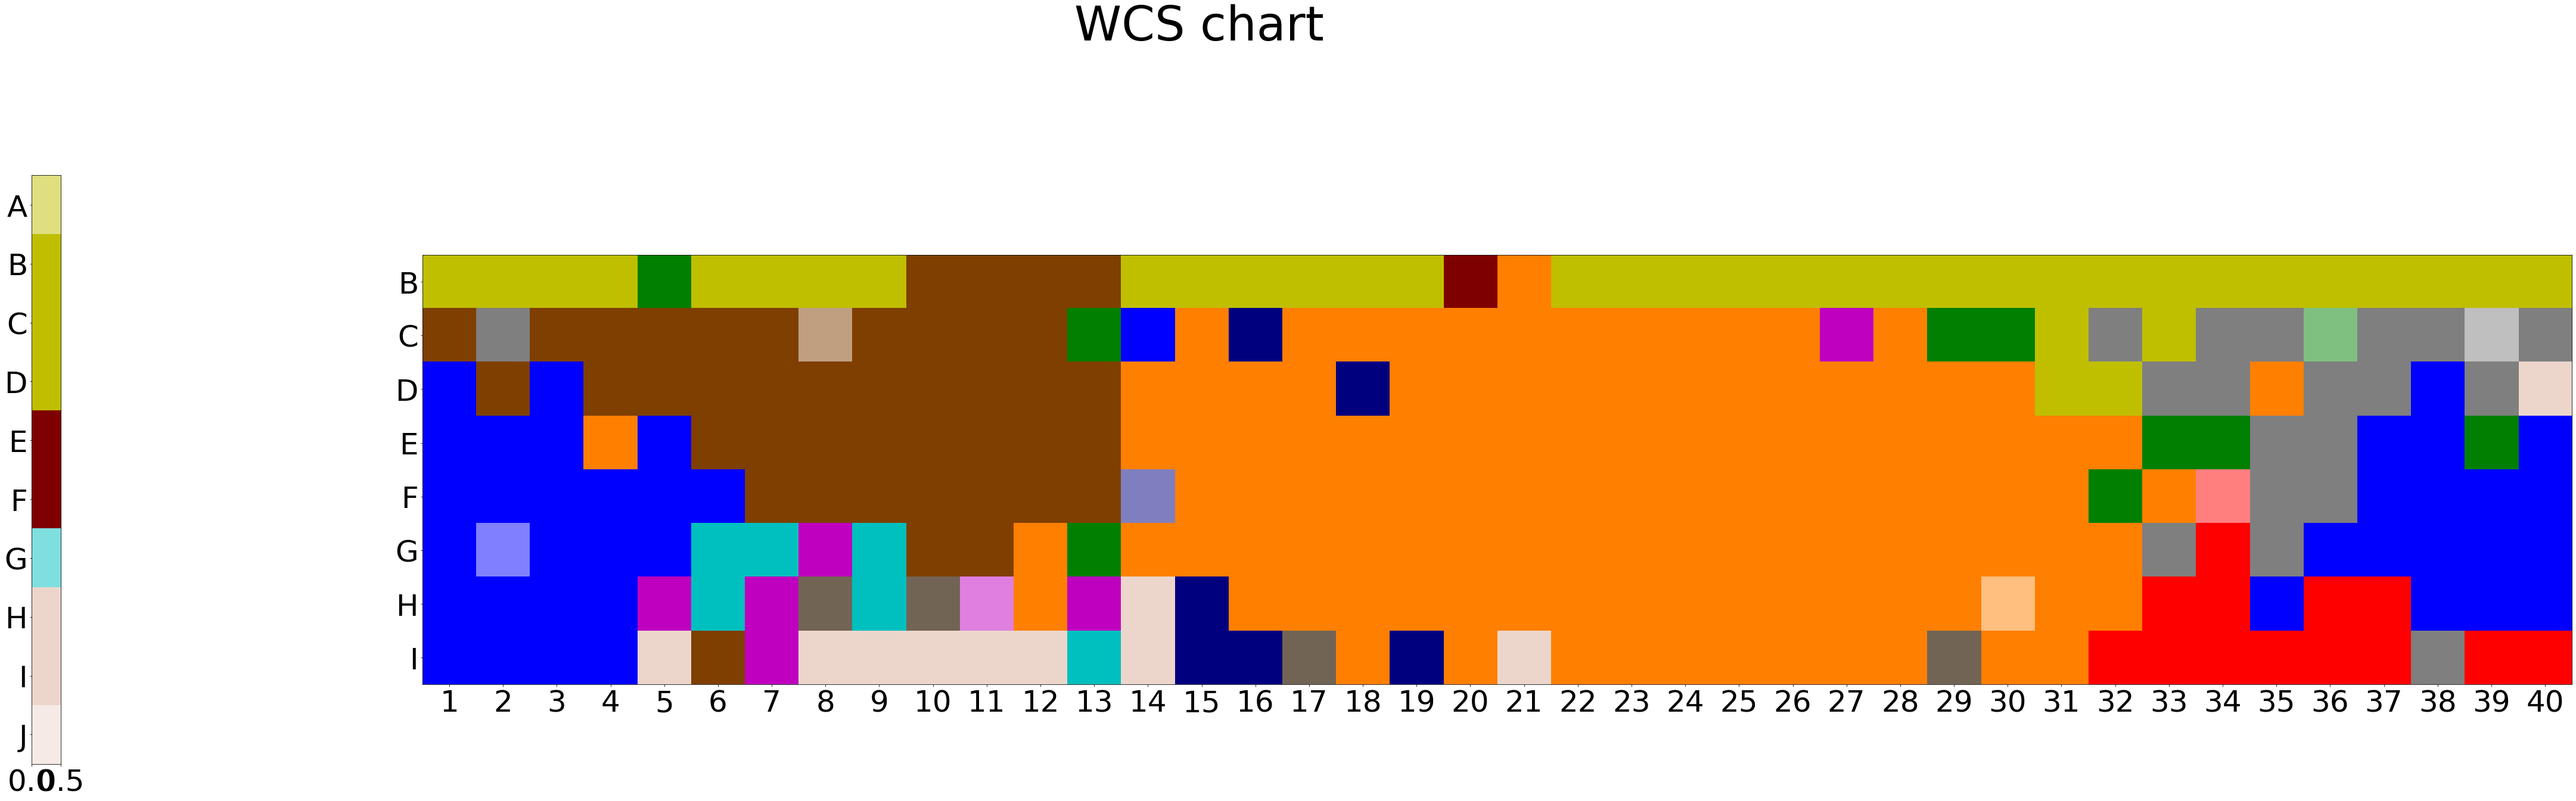

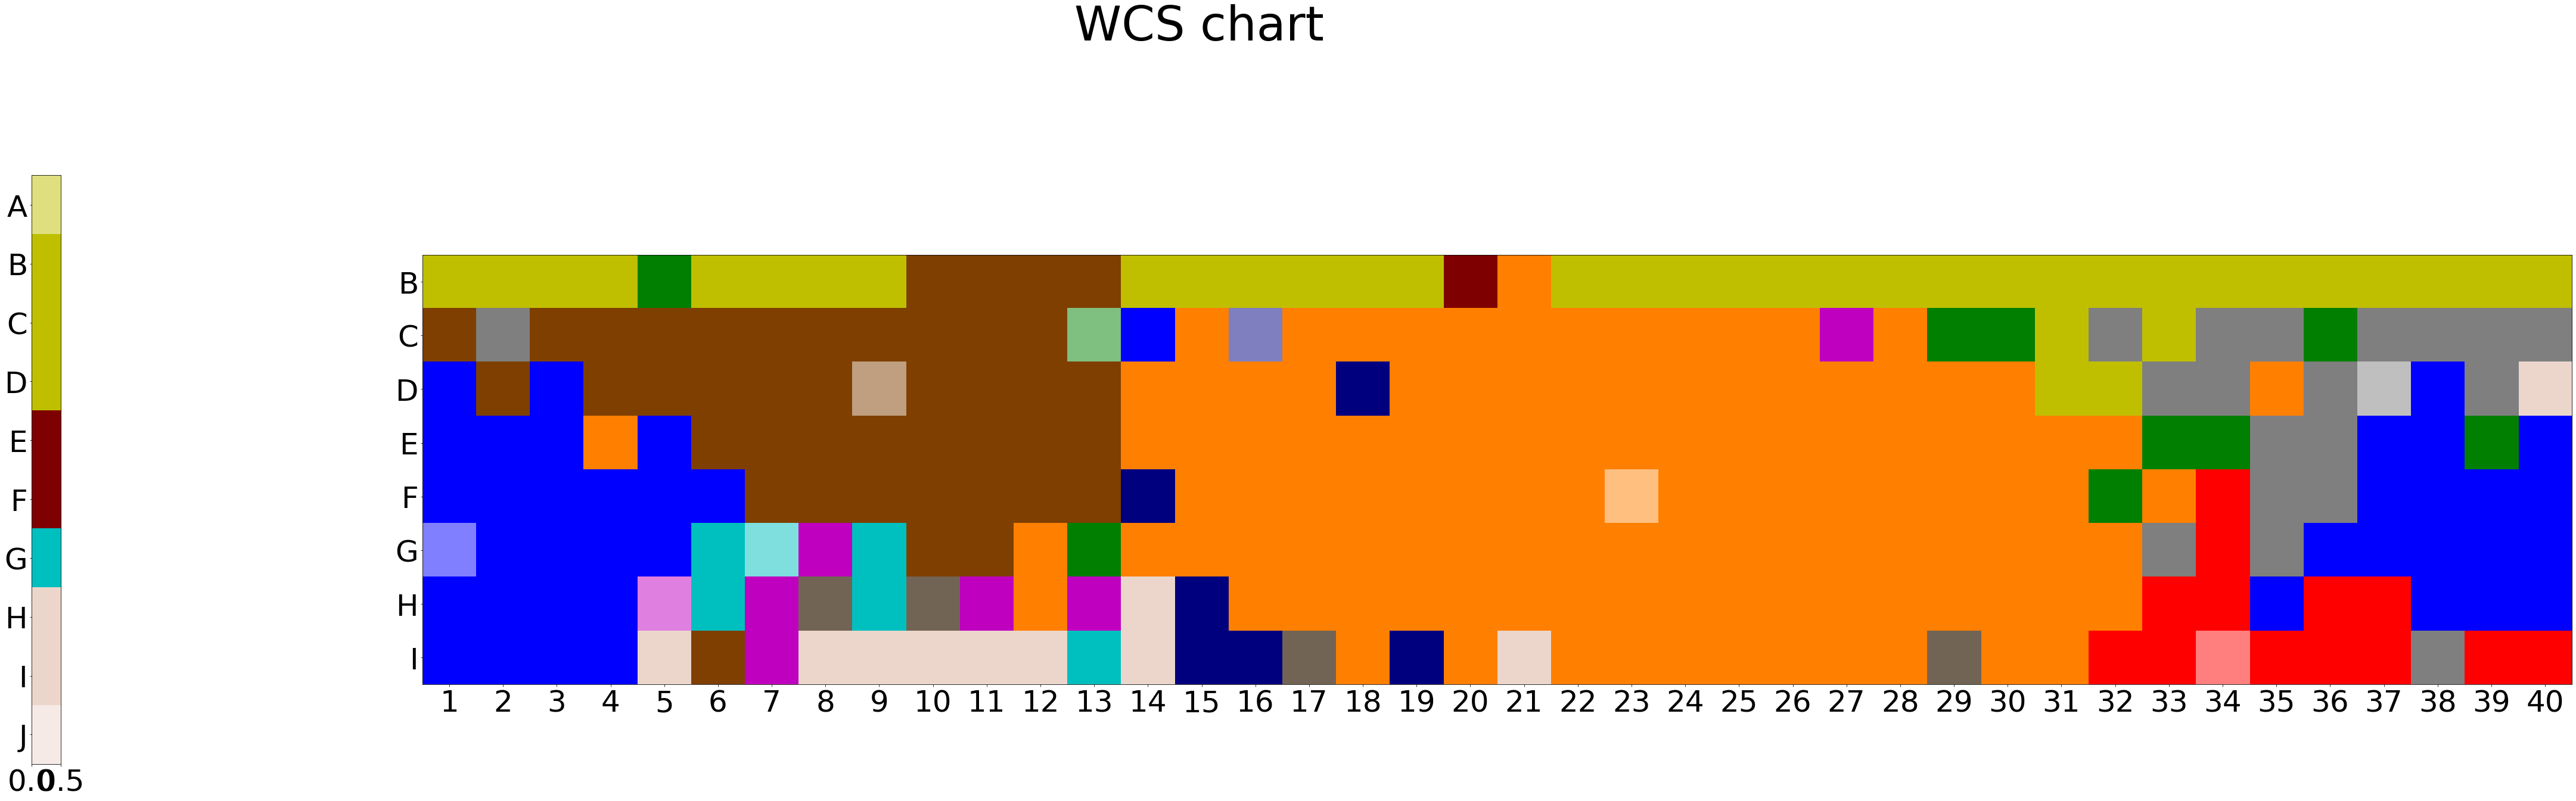

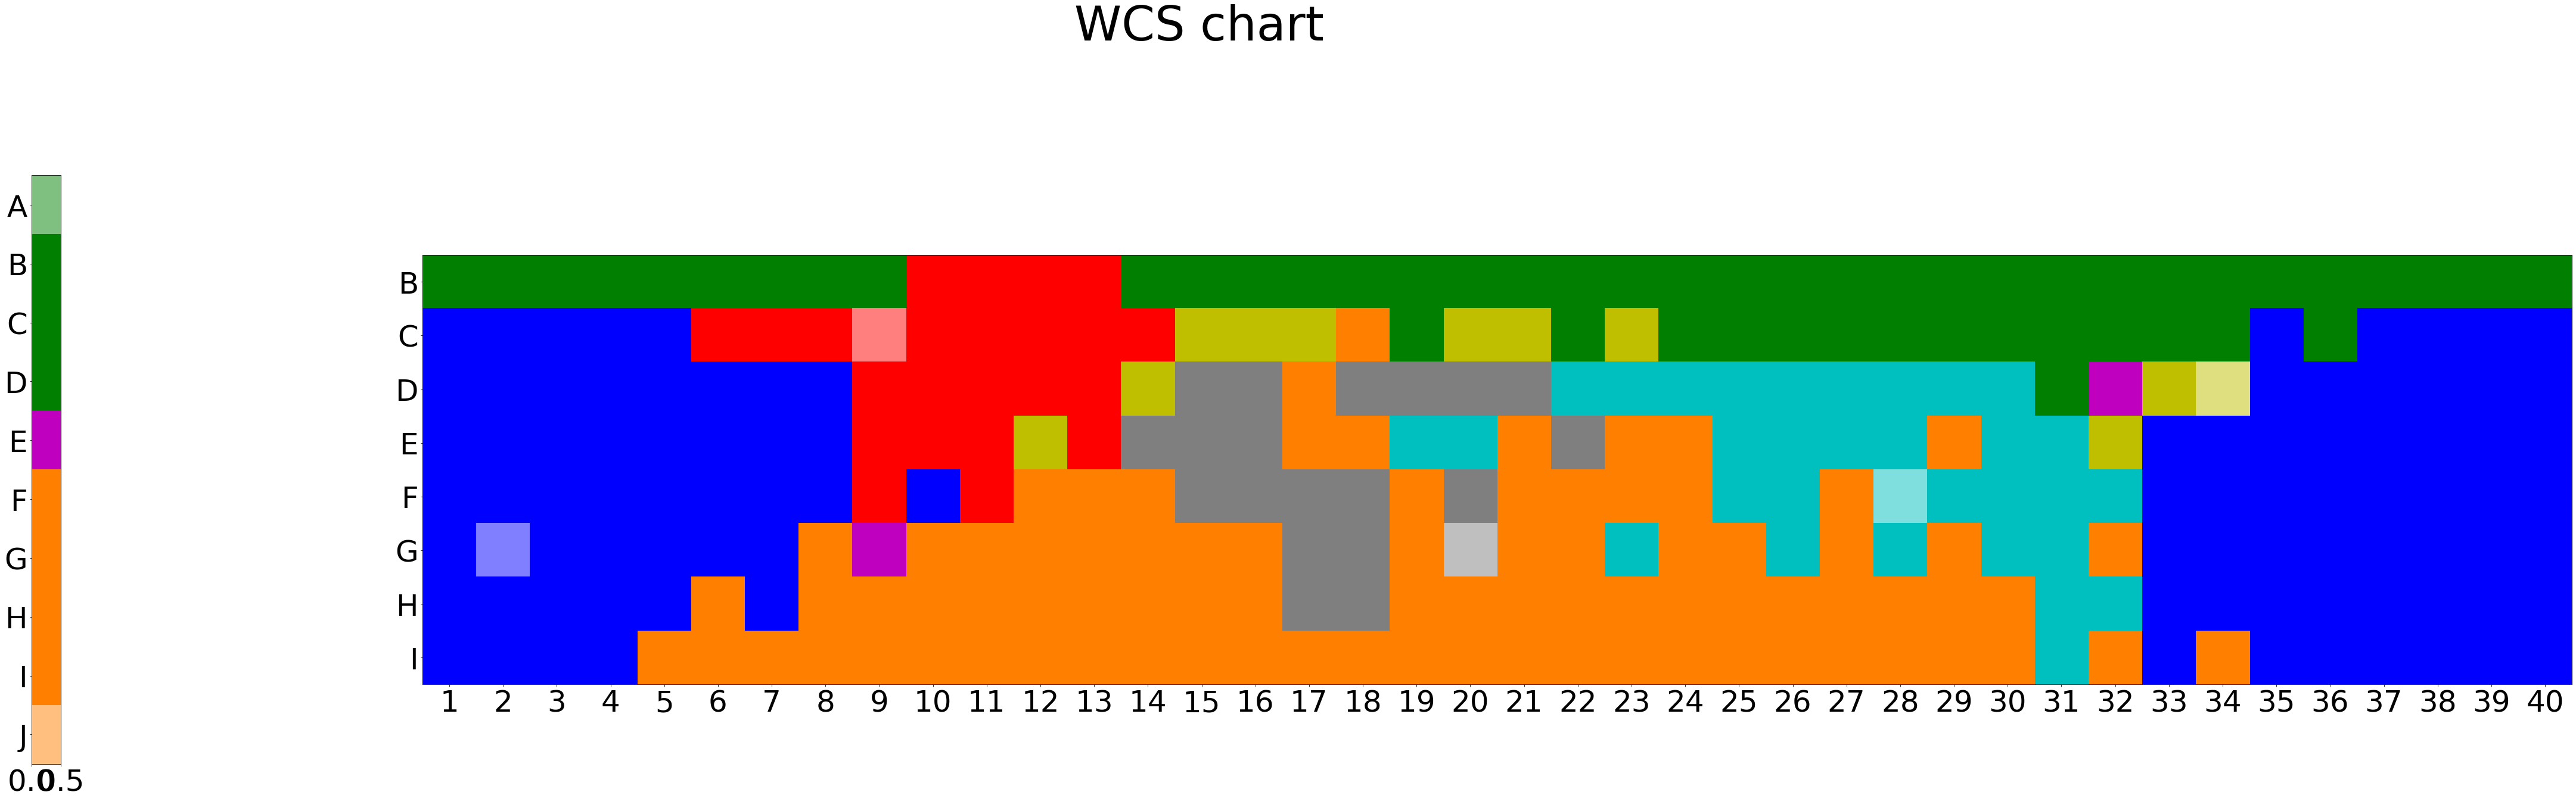

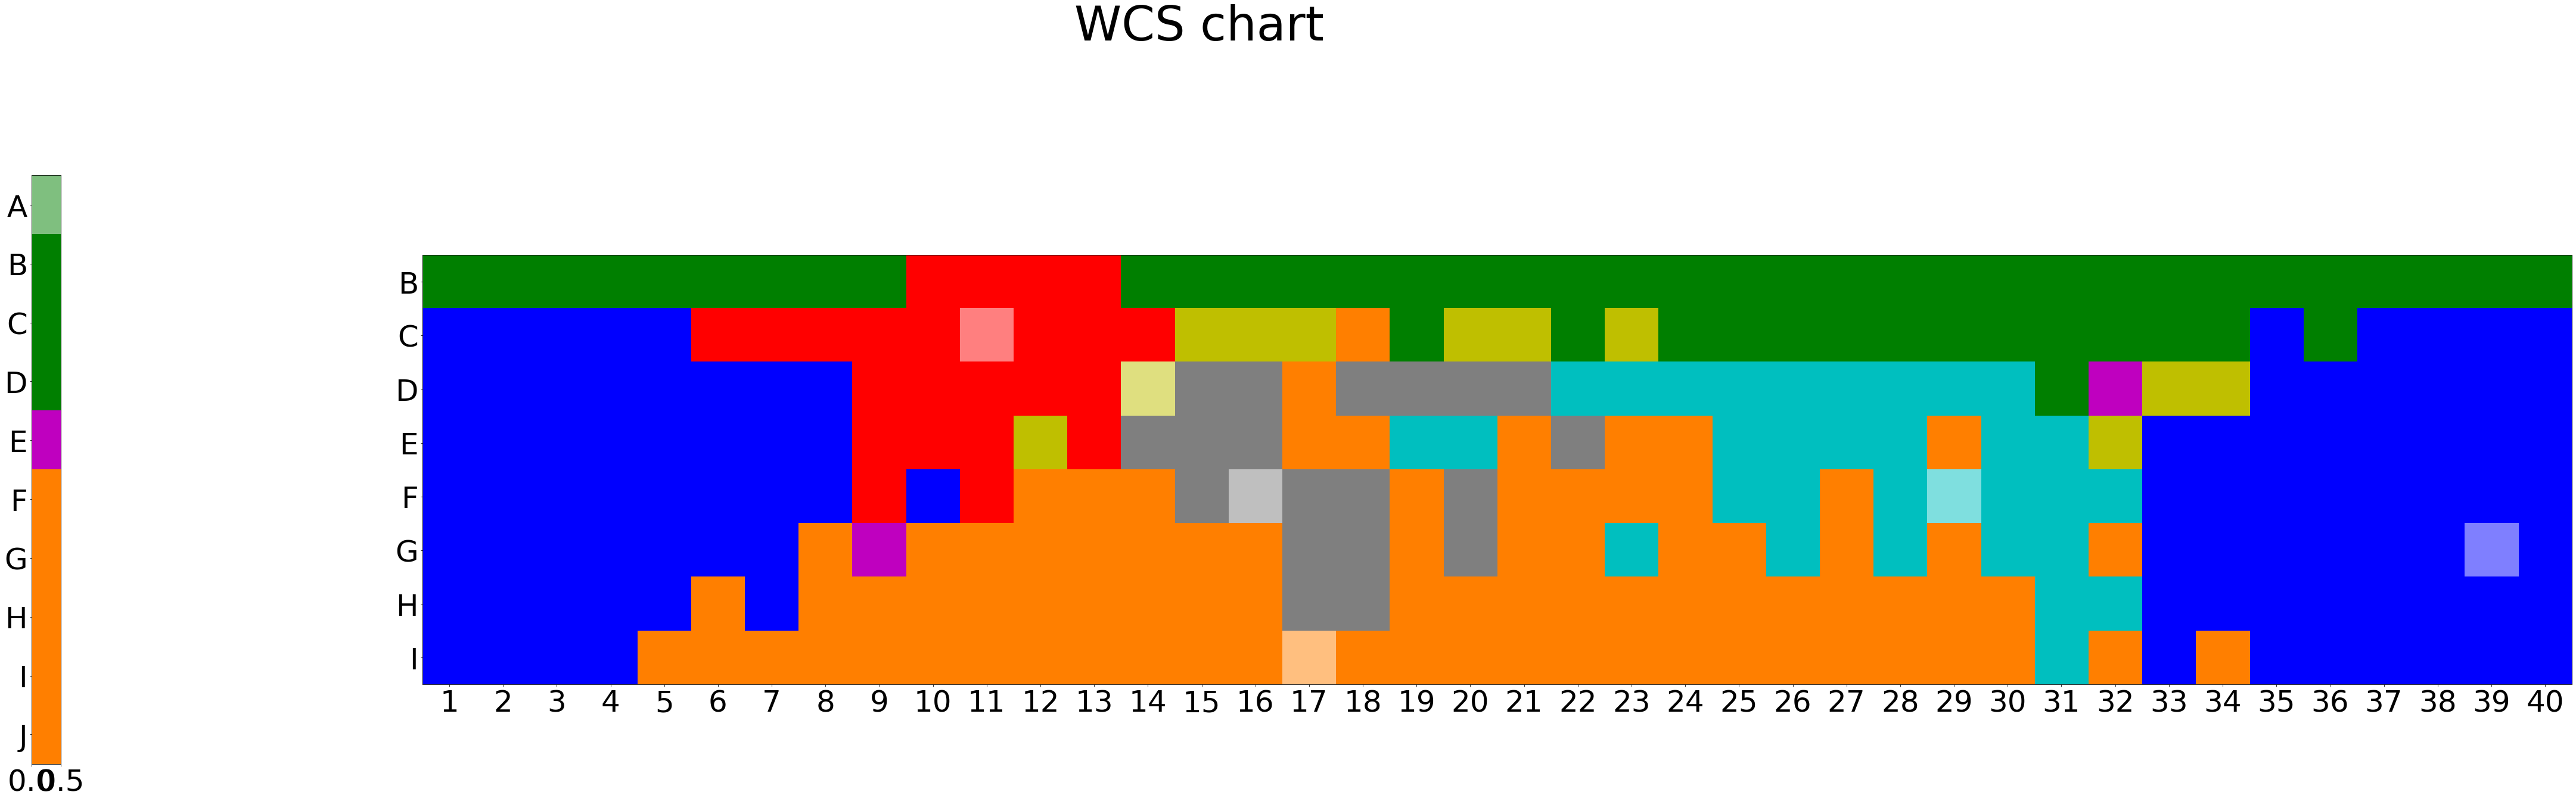

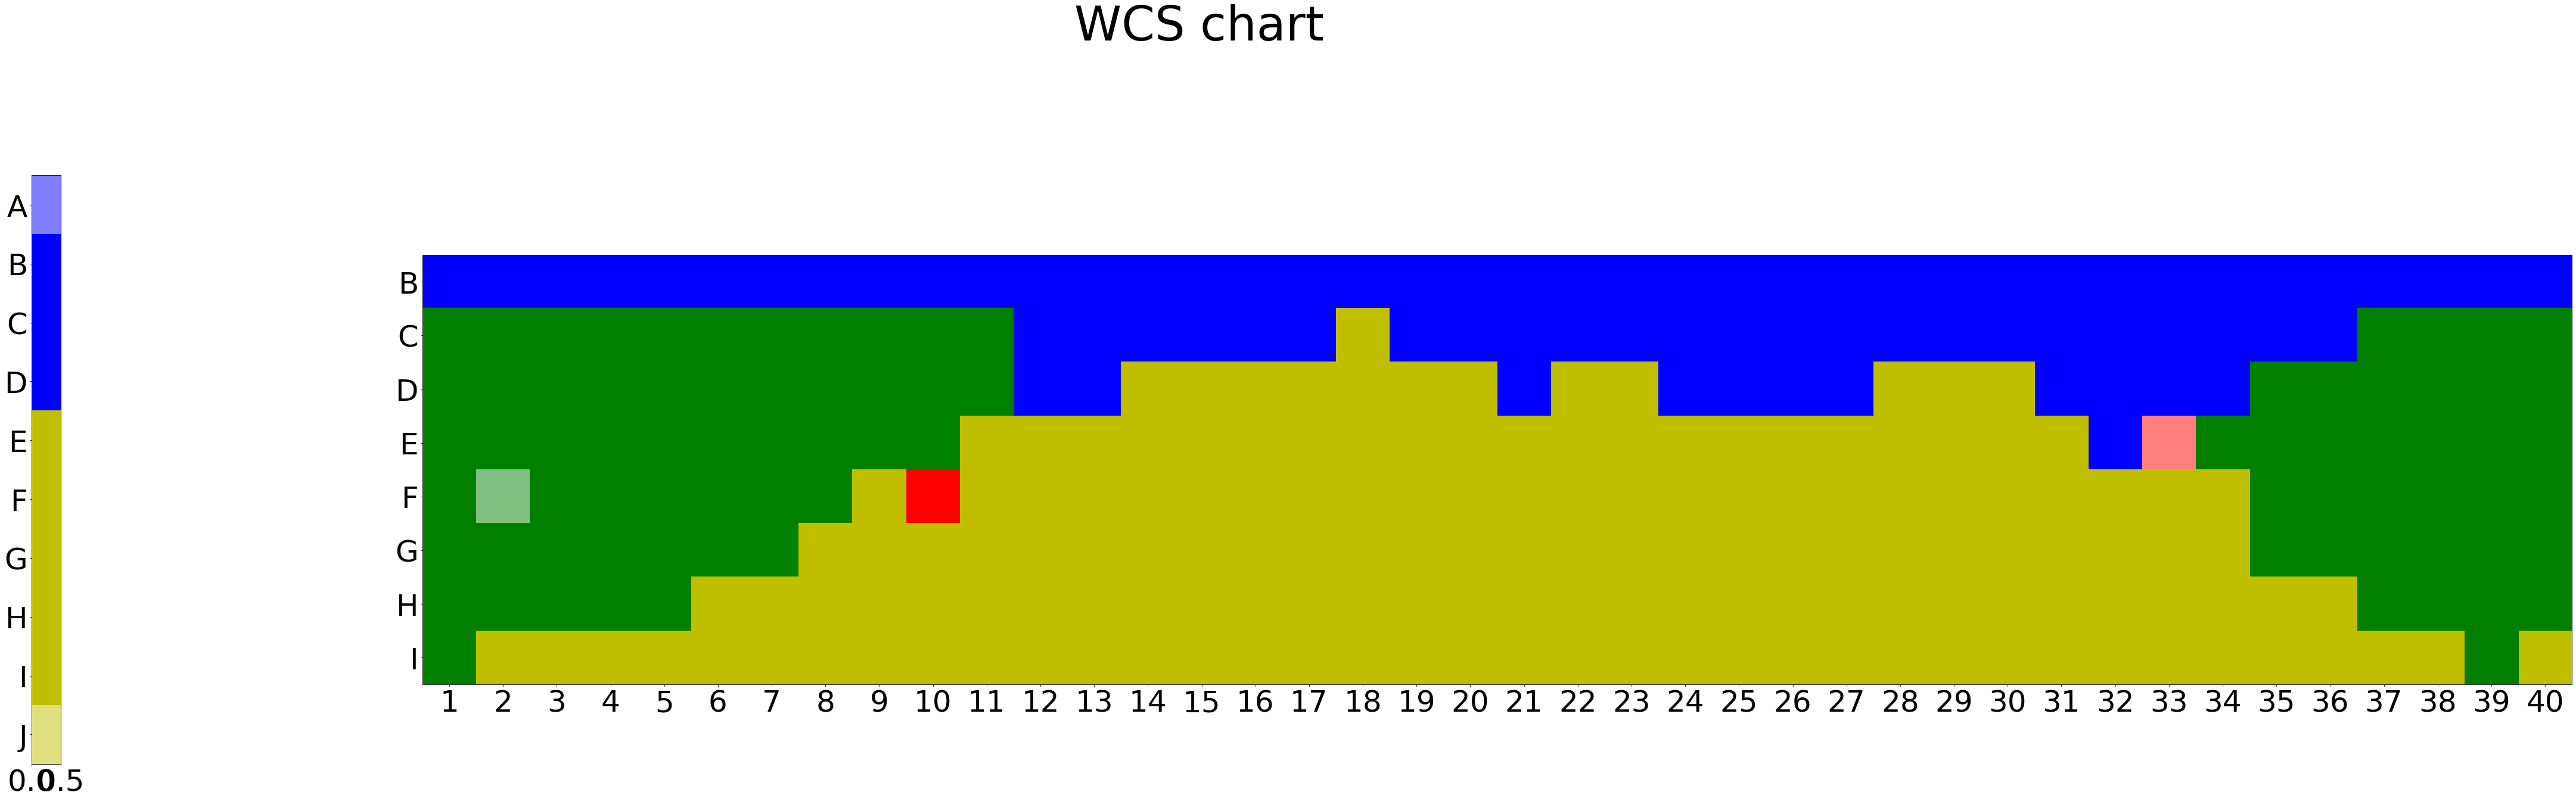

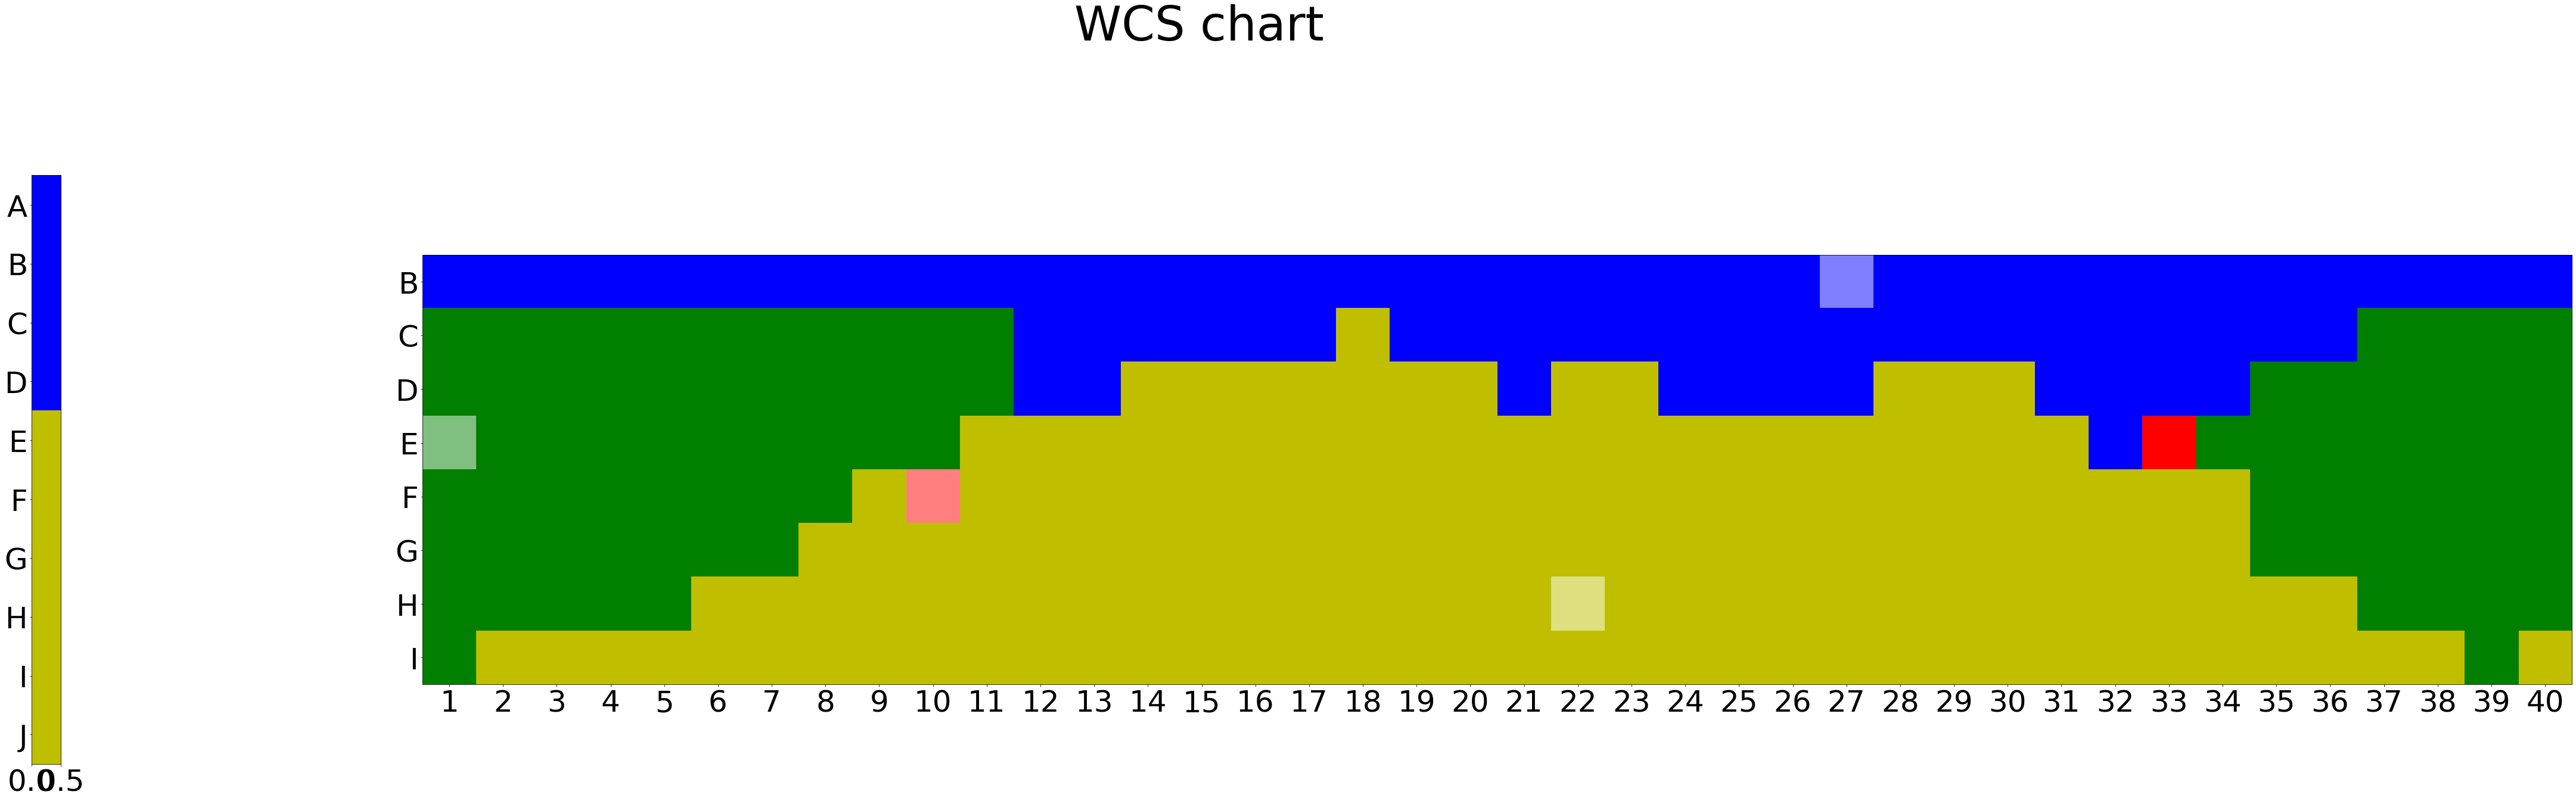

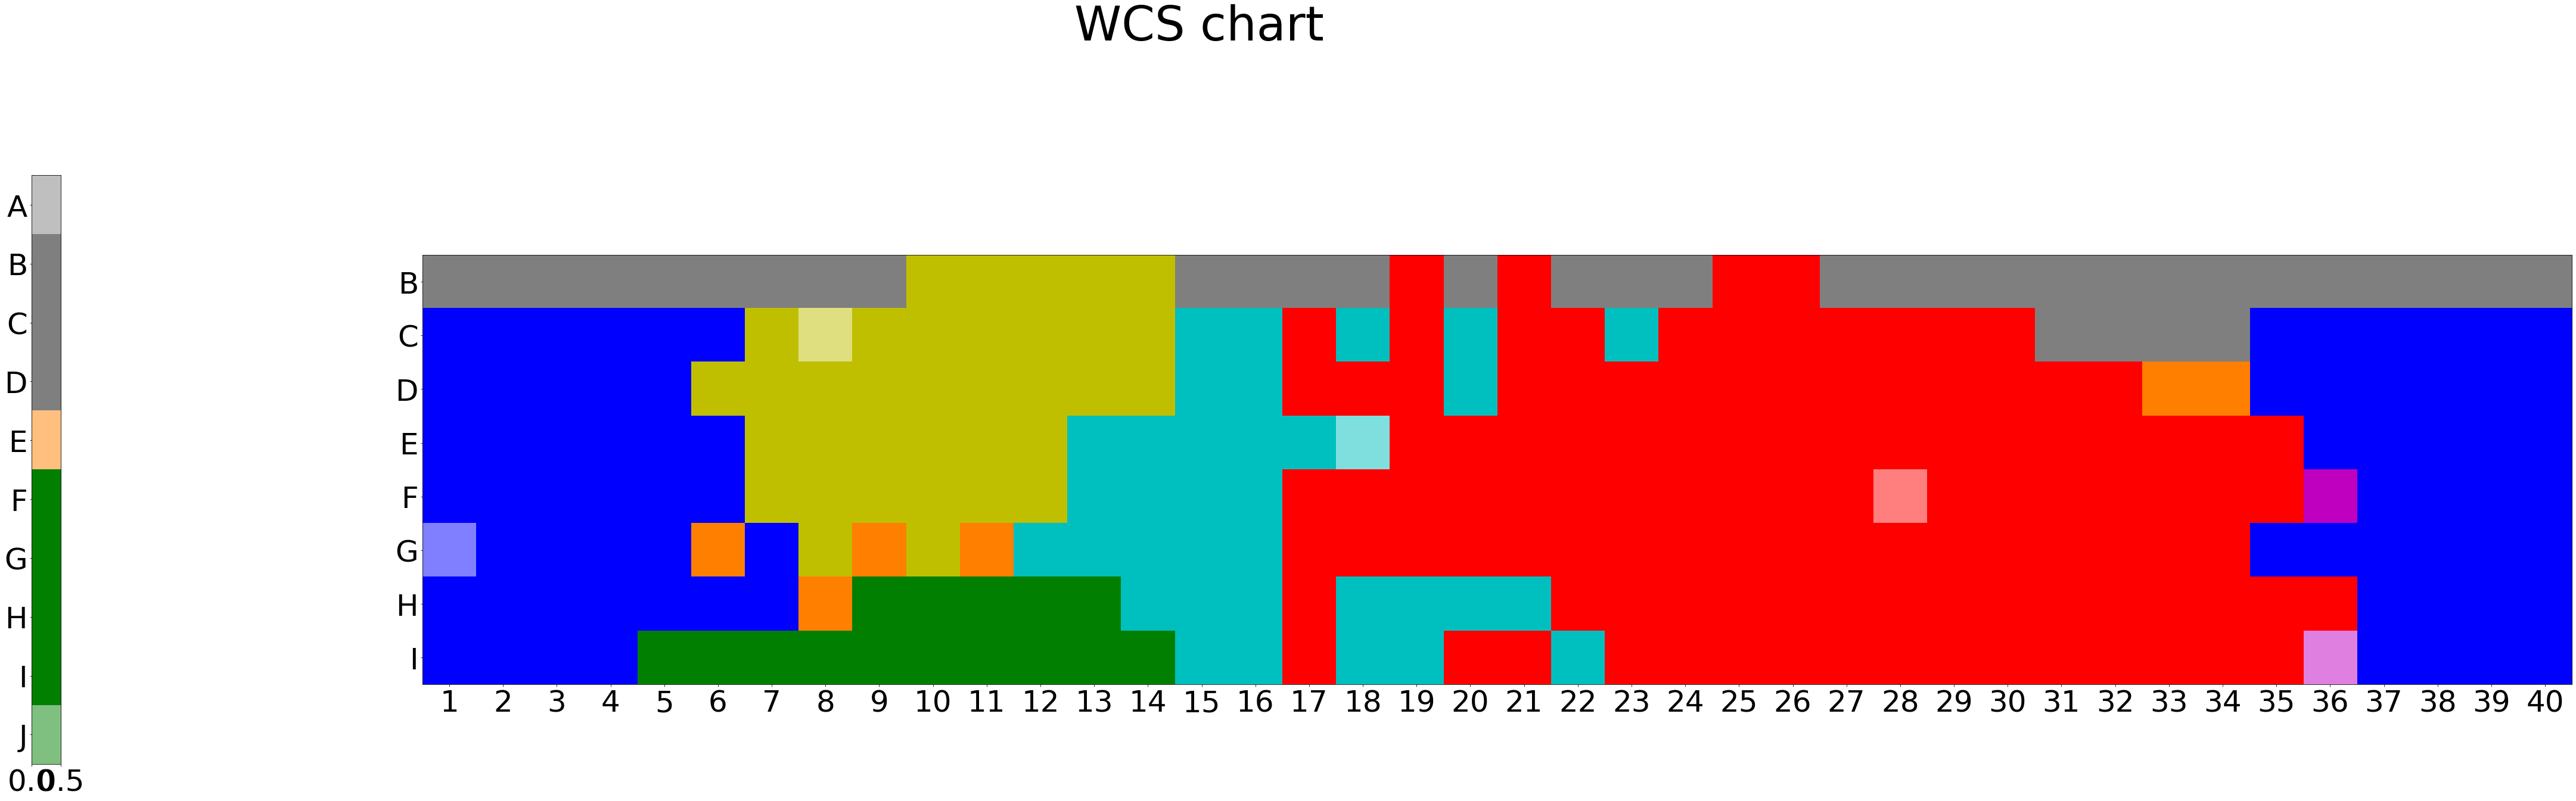

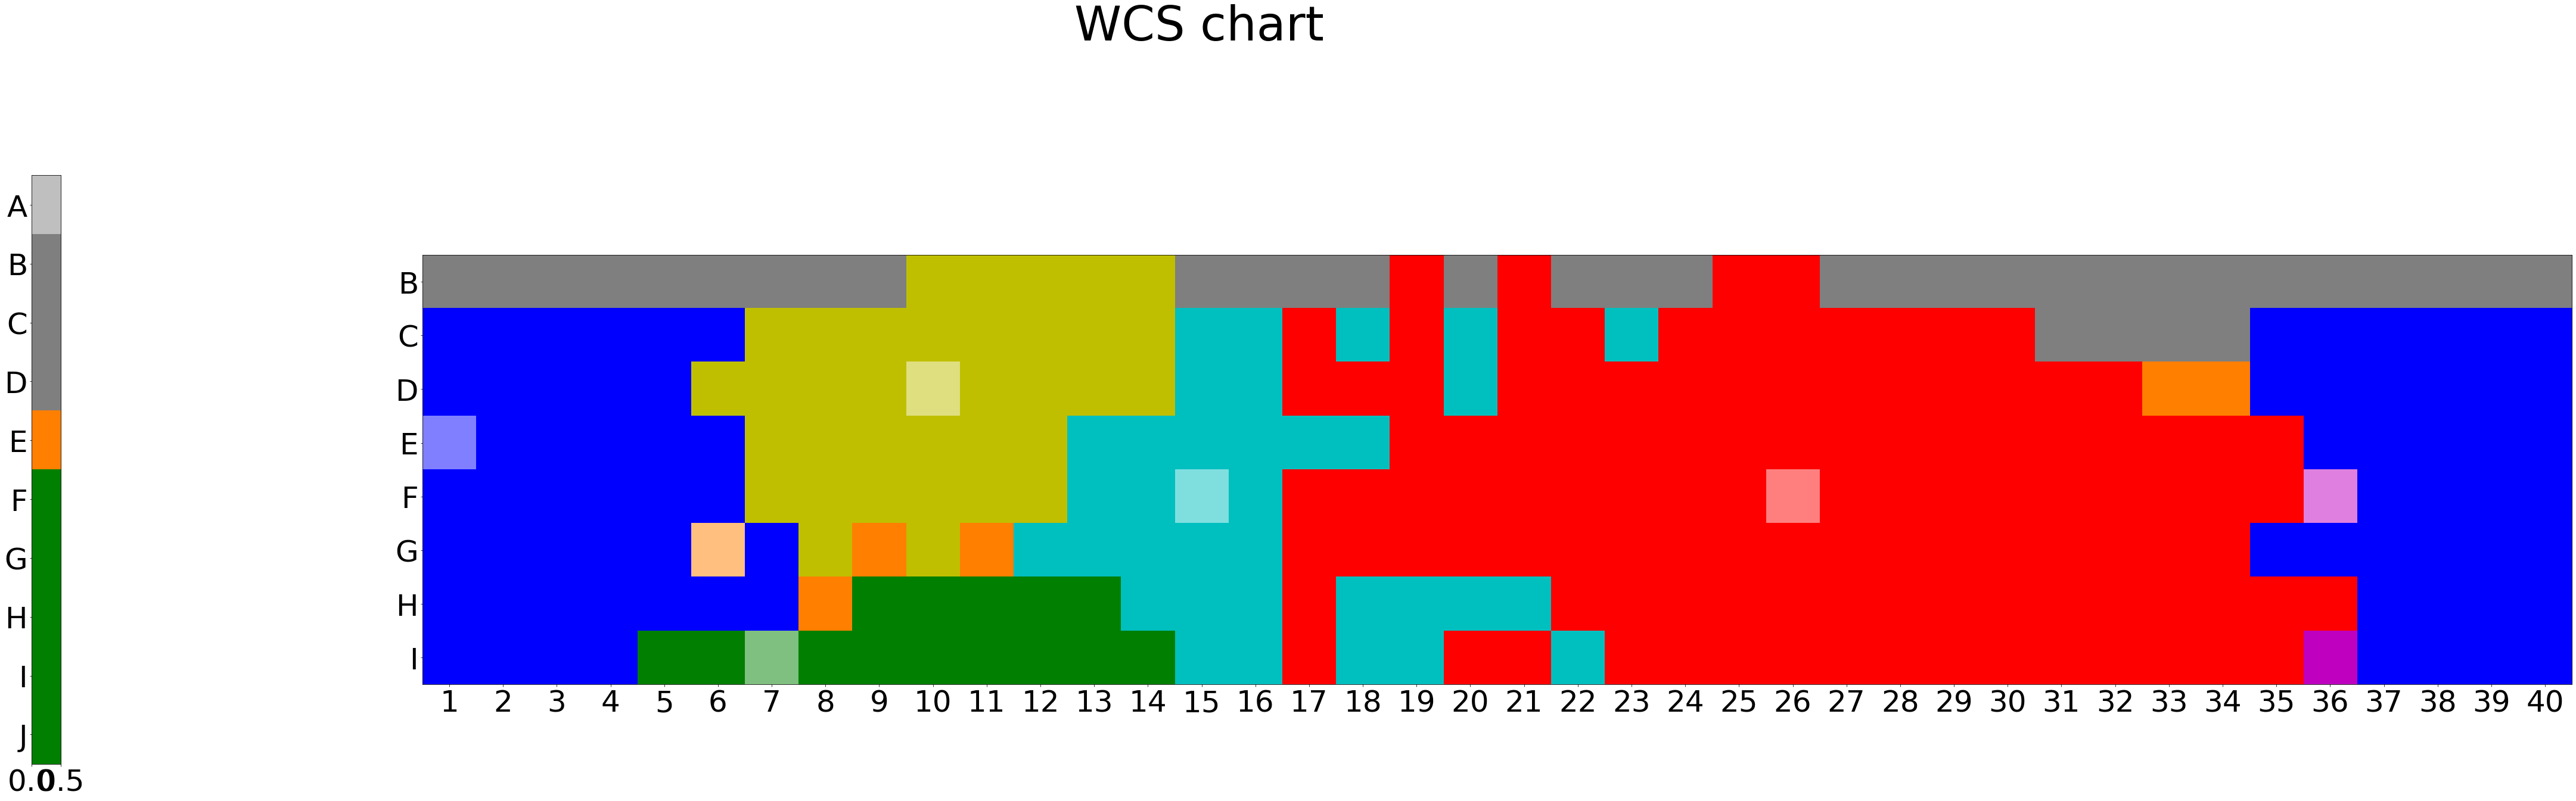

In [45]:
# 5 languages with lowest accuracy for SaD model
for i in range(5):
    language_index = sorted_sad_accuracies[i][0]
    print('Language index:', language_index, '- Accuracy:', sorted_sad_accuracies[i][1])
    catmap = language_modal_maps[language_index]
    terms = list(catmap.values())
    rgbs = generate_rgb_values(terms)
    plot_catmap(catmap, language_empirical_foci[language_index].values(), rgbs)
    plot_catmap(catmap, [language_sad_foci[language_index][gloss] for gloss in language_empirical_foci[language_index]], rgbs)

#### Results of Analysis 1
Below, we can see that SaD accuracy and random accuracy actually have a statistically significant positive correlation.

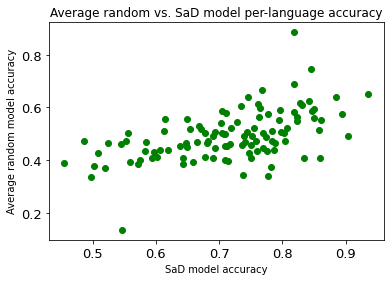

Pearson correlation:  (0.5381538348643372, 1.3333854677669246e-09)


In [46]:
language_sad_accs_list = list(language_sad_accuracies.values())
language_avg_random_accs_list = list(language_avg_random_accuracies.values())

plt.plot(language_sad_accs_list, language_avg_random_accs_list, 'go') 
plt.title('Average random vs. SaD model per-language accuracy')
plt.xlabel('SaD model accuracy')
plt.ylabel('Average random model accuracy')
plt.tick_params(axis = 'both', which = 'major', labelsize = 13)
plt.show()

print("Pearson correlation: ", stats.pearsonr(language_sad_accs_list, language_avg_random_accs_list))

#### Analysis 2 - correlation between accuracy using SaD model and accuracy using prototype model
These two types of accuracy also correlate positively and significantly.

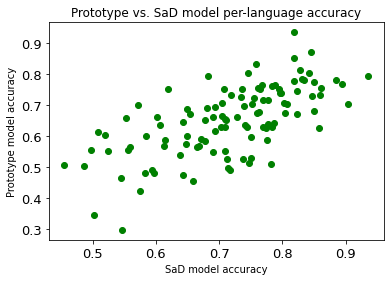

Pearson correlation:  (0.654695464135416, 8.645053928251231e-15)


In [47]:
language_prototype_accs_list = list(language_prototype_accuracies.values())

plt.plot(language_sad_accs_list, language_prototype_accs_list, 'go')
plt.title('Prototype vs. SaD model per-language accuracy')
plt.xlabel('SaD model accuracy')
plt.ylabel('Prototype model accuracy')
plt.tick_params(axis = 'both', which = 'major', labelsize = 13)
plt.show()

print("Pearson correlation: ", stats.pearsonr(language_sad_accs_list, language_prototype_accs_list))